<a href="https://colab.research.google.com/github/MathiasGarnier/Algorithms-All---Old/blob/master/TP1_computational_philology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Computational Philology - TP 01: Exploratory models**
Digital Humanities master's program - PSL
Florian Cafiero and Jean-Baptiste Camps

# Set up

We first start by importing the required packages. This set of packages supports text analysis and data visualization. Pandas and NumPy are used for data manipulation and numerical calculations, while matplotlib and seaborn help visualize data. NLTK and spacy are natural language processing (NLP) tools that analyze and preprocess text. Scikit-learn provides tools for machine learning, clustering, dimensionality reduction, and text vectorization. Torch eventually helps leverage GPU resources for deep learning tasks, such as POS-tagging.

In [1]:
!pip install --upgrade scikit-learn
!pip install functionwordsets
from google.colab import drive
import os
import functionwordsets
import glob
import importlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import torch
from sklearn.manifold import trustworthiness
from nltk.corpus import stopwords
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.preprocessing import normalize
from wordcloud import WordCloud

# Load the French language model for POS tagging

# Function to check if a model is installed (it is a mouthful, but it is useful)
def check_and_download_spacy_model(model_name='fr_core_news_sm'):
    try:
        # Try to load the model
        spacy.load(model_name)
        print(f"Model '{model_name}' is already installed.")
    except OSError:
        # If model is not found, download it
        print(f"Model '{model_name}' not found. Downloading...")
        !python -m spacy download {model_name}

# Check and download the spaCy model if necessary
check_and_download_spacy_model()

# Load the spaCy model
nlp = spacy.load('fr_core_news_sm')
print("Model loaded successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 103.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
Model 'fr_core_news_sm' not found. Downloading...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 131.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Model loaded successfully!


# A bit of caution with encoding

This is an optional yet important preprocessing step: make sure that there are not many artefacts due to various encoding, ocr etc. These various steps are examples of course, and can be selected or not for a particular text, depending on context.

In [2]:
import unicodedata
import re

def normalize_text(text):
    """
    Normalize text by handling encodings, special characters, and spaces.
    """
    # Step 1: Convert to Unicode NFC form to normalize accents or special characters like ç
    text = unicodedata.normalize('NFC', text)

    # Step 2: Replace different types of apostrophes with a single quote
    text = re.sub(r"[’`´‘]", "'", text)

    # Step 3: Replace various quotation marks with standard double quotes
    text = re.sub(r"[“”«»„]", '"', text)

    # Step 4: Remove non-breaking spaces and replace them with regular spaces
    text = re.sub(r"\u00A0", " ", text)

    # Step 5: Remove extra spaces around punctuation
    text = re.sub(r"\s+([?.!,;:])", r"\1", text)
    text = re.sub(r"([?.!,;:])\s+", r"\1 ", text)

    # Step 6: Convert text to lowercase, if the case is not significant, or not authorial (editor/scribe etc.))
    text = text.lower()

    # Step 7: Strip leading and trailing spaces
    text = text.strip()

    return text

# Example usage
sample_text = "« Voilà un exemple génial ! » disait-il. « Qu’est-ce que tu en penses ? » Personne ne répondit, son collègue finissait encore son café."
normalized_text = normalize_text(sample_text)
print("Original:", sample_text)
print("Normalized:", normalized_text)

Original: « Voilà un exemple génial ! » disait-il. « Qu’est-ce que tu en penses ? » Personne ne répondit, son collègue finissait encore son café.
Normalized: " voilà un exemple génial! " disait-il. " qu'est-ce que tu en penses? " personne ne répondit, son collègue finissait encore son café.


# Loading the corpus

## Defining  a function to optionally normalize

In [3]:
def load_corpus(data_path, normalize=True):
    """
    Load and optionally normalize all text files in the specified directory.

    Parameters:
    - data_path (str): Path to the directory containing text files.
    - normalize (bool): Whether to normalize the text or not.

    Returns:
    - corpus_data (list): List of text documents.
    - file_names (list): List of corresponding file names.
    """
    corpus_data = []
    file_names = []

    # Iterate over all text files in the directory
    for file_path in glob.glob(os.path.join(data_path, '*.txt')):
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read().strip()

                # Apply normalization if the user chooses to
                if normalize:
                    text = normalize_text(text)

                if text:  # Ensure the file is not empty after optional normalization
                    corpus_data.append(text)
                    file_names.append(os.path.basename(file_path))
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    # Check if we have successfully loaded documents
    if not corpus_data:
        raise ValueError("No documents were loaded. Please check the file path and contents.")

    return corpus_data, file_names

## Loading our corpus

In [7]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
data_path = '/content/drive/MyDrive/Dumaquet'
os.chdir(data_path)

# Set up device for GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

# Load corpus with optional normalization
normalize_option = True  # Set to False if you don't want normalization
corpus_data, file_names = load_corpus(data_path, normalize=normalize_option)

# Display the results
print(f"Successfully loaded {len(corpus_data)} documents with normalization set to {normalize_option}.")
print(f"Sample document: {corpus_data[0][:500]}")

Mounted at /content/drive
Using device: GPU
Successfully loaded 26 documents with normalization set to True.
Sample document: i

conseils


rodolphe et clémence causaient ensemble pendant que m. d'harville
lisait par deux fois la lettre de sarah. les traits du marquis restèrent calmes; un tremblement nerveux presque
imperceptible agita seulement sa main, lorsque après un moment
d'hésitation il mit le billet dans la poche de son gilet. --au risque de passer encore pour un sauvage, dit-il à rodolphe en
souriant, je vous demanderai la permission, monseigneur, d'aller
répondre à cette lettre... plus importante que je ne le


# Restoring balance in the corpus

First thing to do is to check whether the corpus seems homogenous enough or not, at least regarding the length of its texts.

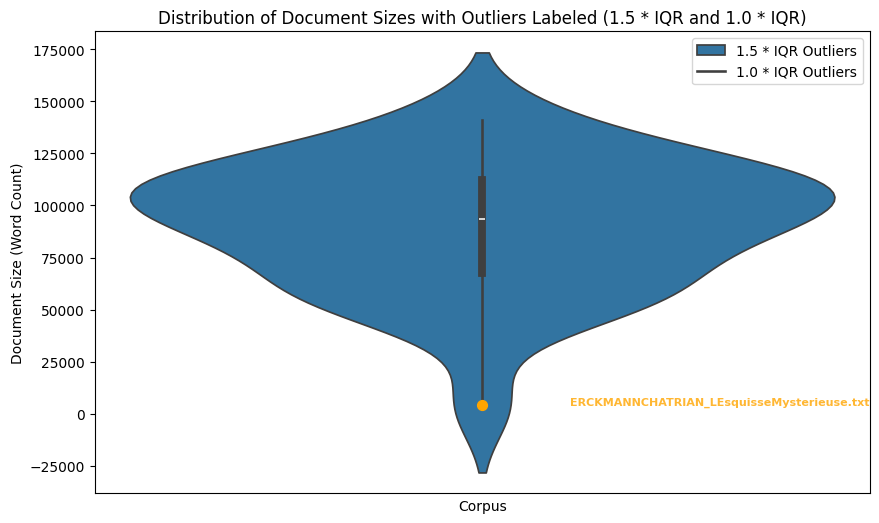

Outliers (1.5 * IQR):

Outliers (1.0 * IQR):
ERCKMANNCHATRIAN_LEsquisseMysterieuse.txt - Size: 4442


In [8]:
# Calculate word counts for each document
word_counts = [len(doc.split()) for doc in corpus_data]
sizes_df = pd.DataFrame(word_counts, columns=["Document Size"])

# Calculate outliers based on IQR with two different thresholds
Q1 = sizes_df["Document Size"].quantile(0.25)
Q3 = sizes_df["Document Size"].quantile(0.75)
IQR = Q3 - Q1

# Define two different outlier thresholds
# détection de points aberrant
# écarts type q3 q1
outlier_threshold_upper_1_5 = Q3 + 1.5 * IQR
outlier_threshold_lower_1_5 = Q1 - 1.5 * IQR

outlier_threshold_upper_1_0 = Q3 + 1.0 * IQR
outlier_threshold_lower_1_0 = Q1 - 1.0 * IQR

# Identify outliers for both thresholds
outliers_1_5 = sizes_df[(sizes_df["Document Size"] > outlier_threshold_upper_1_5) |
                        (sizes_df["Document Size"] < outlier_threshold_lower_1_5)]
outliers_1_0 = sizes_df[(sizes_df["Document Size"] > outlier_threshold_upper_1_0) |
                        (sizes_df["Document Size"] < outlier_threshold_lower_1_0)]

# Plot the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=sizes_df, y="Document Size", inner="box")

# Add outlier points with both thresholds
for idx in outliers_1_5.index:
    plt.scatter(0, word_counts[idx], color="red", s=50, zorder=3)
    plt.text(
        0.1, word_counts[idx], file_names[idx], ha="left", fontsize=8, color="red",
        weight="bold", alpha=0.8, zorder=4, label="Outlier 1.5 * IQR"
    )

for idx in outliers_1_0.index:
    plt.scatter(0, word_counts[idx], color="orange", s=50, zorder=3)
    plt.text(
        0.1, word_counts[idx], file_names[idx], ha="left", fontsize=8, color="orange",
        weight="bold", alpha=0.8, zorder=4, label="Outlier 1.0 * IQR"
    )

plt.title("Distribution of Document Sizes with Outliers Labeled (1.5 * IQR and 1.0 * IQR)")
plt.ylabel("Document Size (Word Count)")
plt.xlabel("Corpus")
plt.xticks([])
plt.legend(["1.5 * IQR Outliers", "1.0 * IQR Outliers"])
plt.show()

# Print outlier filenames and sizes for reference
print("Outliers (1.5 * IQR):")
for idx in outliers_1_5.index:
    print(f"{file_names[idx]} - Size: {word_counts[idx]}")

print("\nOutliers (1.0 * IQR):")
for idx in outliers_1_0.index:
    print(f"{file_names[idx]} - Size: {word_counts[idx]}")


## Optional removal of outliers

In [ ]:
# Choose the outlier removal option: '1.5', '1.0', or 'none'
outlier_removal_option = '1.5'  # change to '1.0' or 'none' if needed

# Keep a one-time snapshot of the original data (so re-running doesn't double-filter)
if 'original_file_names' not in globals():
    original_file_names = list(file_names)
if 'original_corpus_data' not in globals():
    original_corpus_data = list(corpus_data)

# Map option -> index set (these indices must refer to the ORIGINAL ordering)
if outlier_removal_option == '1.5':
    outlier_indices = set(outliers_1_5.index)
elif outlier_removal_option == '1.0':
    outlier_indices = set(outliers_1_0.index)
elif outlier_removal_option == 'none':
    outlier_indices = set()
else:
    raise ValueError("Invalid outlier removal option. Choose '1.5', '1.0', or 'none'.")

# Build a kept mask against the ORIGINAL list
n_orig = len(original_file_names)
kept_mask = [i not in outlier_indices for i in range(n_orig)]
kept_idx  = [i for i, keep in enumerate(kept_mask) if keep]  # useful if you need to filter other arrays

# Filter from the ORIGINAL snapshots to avoid cumulative filtering
filtered_file_names  = [original_file_names[i]  for i in kept_idx]
filtered_corpus_data = [original_corpus_data[i] for i in kept_idx]

# Overwrite legacy variables so downstream cells keep working as before
file_names  = filtered_file_names
corpus_data = filtered_corpus_data

# Rebuild prefixes (used for coloring) from the filtered names
prefixes = [fn.split("_")[0] for fn in file_names]

# Basic sanity checks
assert len(file_names) == len(corpus_data), "Names and documents length mismatch after filtering."

print(f"Outlier option: {outlier_removal_option} — removed {n_orig - len(file_names)} of {n_orig} docs.")
print("Number of documents after outlier removal:", len(file_names))
print("Remaining files:", file_names)


Outlier option: 1.5 — removed 0 of 26 docs.
Number of documents after outlier removal: 26
Remaining files: ['DUMAS_LeCapitaineArenaT2.txt', 'DUMAS_LeCapitaineArenaT1.txt', 'DUMAS_LeCapitainePaul.txt', 'DUMASMAQUET_CollierDeLaReineT1.txt', 'DUMASMAQUET_CollierDeLaReineT2.txt', 'DUMASMAQUET_LesQuaranteCinqT1.txt', 'DUMASMAQUET_LesQuaranteCinqT2.txt', 'DUMASMAQUET_LesQuaranteCinqT3.txt', 'DUMASMAQUET_MonteCristoT1.txt', 'DUMASMAQUET_MonteCristoT2.txt', 'DUMASMAQUET_MonteCristoT3.txt', 'DUMASMAQUET_MonteCristoT4.txt', 'ERCKMANNCHATRIAN_LAmiFritz.txt', 'ERCKMANNCHATRIAN_LEsquisseMysterieuse.txt', 'ERCKMANNCHATRIAN_MadameTherese.txt', 'GONCOURT_GerminieLacerteux.txt', 'GONCOURT_HistoireDeMarieAntoinette.txt', 'GONCOURT_ManetteSalomon.txt', 'MAQUET_LaBelleGabrielleT1.txt', 'MAQUET_LaBelleGabrielleT2.txt', 'MAQUET_LaBelleGabrielleT3.txt', 'SUE_MysteresParisT1.txt', 'SUE_MysteresParisT2.txt', 'SUE_MysteresParisT3.txt', 'SUE_MysteresParisT4.txt', 'SUE_MysteresParisT5.txt']


# Handling function words

One possibility would be to use a list of stopwords already provided in an NLP package such as NLTK.

In [ ]:
# Download the stopwords if not already available
nltk.download('stopwords')

# Get the French stopwords
french_stopwords = stopwords.words('french')

# Organize stopwords into a DataFrame for better readability
num_columns = 9  # Define the number of columns for display
stopwords_table = pd.DataFrame([french_stopwords[i:i + num_columns] for i in range(0, len(french_stopwords), num_columns)])
stopwords_table = stopwords_table.fillna('')  # Replace None values with empty strings
print(stopwords_table.to_string(index=False, header=False))

      au      aux    avec      ce    ces    dans      de     des     du
    elle       en      et     eux     il     ils      je      la     le
     les     leur     lui      ma   mais      me    même     mes    moi
     mon       ne     nos   notre   nous      on      ou     par    pas
    pour       qu     que     qui     sa      se     ses     son    sur
      ta       te     tes     toi    ton      tu      un     une    vos
   votre     vous       c       d      j       l       à       m      n
       s        t       y     été   étée   étées    étés   étant étante
  étants  étantes    suis      es    est  sommes    êtes    sont  serai
   seras     sera  serons   serez seront  serais  serait serions seriez
seraient    étais   était  étions  étiez étaient     fus     fut  fûmes
   fûtes   furent    sois    soit soyons   soyez  soient   fusse fusses
     fût fussions fussiez fussent  ayant  ayante ayantes  ayants     eu
     eue     eues     eus      ai     as   avons    avez     ont

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


However, the list is somehow disappointing in most treatments, and not easy to customize - which we often want to do in stylometry, as what is content-related actually depends on the genre of the text. We thus use a package where function words are ordered according to grammatical nature, functionwordsets.

In [ ]:
# Load the French 21st-century set (change if you use another ID)
ds = functionwordsets.load("fr_21c")

# See all category keys (including 'pers_pron'):
print(sorted(ds.categories.keys()))

# Peek at what’s inside 'pers_pron' to be sure you are adding / removing what you want
print(sorted(list(ds.categories["pers_pron"]))[:20])

# Build the union of all categories EXCEPT personal pronouns
keep_keys = [k for k in ds.categories.keys() if k != "pers_pron"]
function_words = set().union(*(ds.categories[k] for k in keep_keys))

# (Optional) aliases if you used these names later in a not so clean code like mine for now (FC)
FUNCTION_WORDS = function_words
STOPWORDS = function_words
stopwords = function_words

# (Optional) helper if some code lowercases tokens before membership tests
FUNCTION_WORDS_LOWER = {w.lower() for w in function_words}
def is_function_word(tok: str) -> bool:
    return tok in function_words or tok.lower() in FUNCTION_WORDS_LOWER


['adv_locutions', 'adverbs', 'articles', 'aux_avoir', 'aux_être', 'coord_conj', 'dem_pron', 'indef_pron', 'inter_pron', 'modals_full', 'negations', 'pers_pron', 'poss_det', 'poss_pron', 'prepositions', 'subord_conj']
['elle', 'elles', 'en', 'eux', 'il', 'ils', "j'", 'je', "l'", 'la', 'le', 'les', 'leur', 'lui', "m'", 'me', 'moi', 'nous', 'on', "s'"]


Both approaches present a problem: some words are of ambiguous nature. In French e.g., "or" can mean "yet" or "now", but can also mean "gold" if it is a noun. POS tagging can thus be very useful. But be careful, it takes a while ! We need to POS-tag the corpus as a whole, then filter accordingly.

**The Mr Obvious moment**: POS-tagging needs context, if you run it on the words that only interest you, it will be quicker, yet completely useless ("thank you, Mr Obvious!")

In [ ]:
# --- Function-word extraction with POS tagging (case-insensitive match) ---
# What this cell does:
# 1) POS-tag each document on the original text (better tagging quality).
# 2) Keep tokens whose POS is among function-word POS tags AND whose surface form
#    is in your function-word lexicon (case-insensitive check).
# 3) Optionally convert the final filtered text to lowercase (enabled below).

# POS tags considered as function words
function_pos_tags = {
    'DET',    # Determiners
    'PRON',   # Pronouns
    'ADP',    # Prepositions
    'CCONJ',  # Coordinating conjunctions
    'SCONJ',  # Subordinating conjunctions
    'AUX',    # Auxiliary verbs
    'ADV',    # Adverbs
    'PART'    # Particles
}

# Toggle: if True, the final filtered corpus is fully lowercased
APPLY_LOWERCASE_AFTER_FILTERING = True  # enabled as requested

# Assumes `function_words` already exists (e.g., from functionwordsets without 'pers_pron')
FUNCTION_WORDS = set(function_words)
FUNCTION_WORDS_LOWER = {w.lower() for w in FUNCTION_WORDS}

def filter_function_words_case_safe(text, pos_tags, fw_set, fw_set_lower):
    """Tag with spaCy, filter by POS and lexicon (case-insensitive), return original casing."""
    doc = nlp(text)
    kept = []
    for tok in doc:
        if tok.pos_ in pos_tags and (tok.text in fw_set or tok.text.lower() in fw_set_lower):
            kept.append(tok.text)
    return ' '.join(kept)

# Build the filtered corpus
function_words_corpus_data = [
    filter_function_words_case_safe(text, function_pos_tags, FUNCTION_WORDS, FUNCTION_WORDS_LOWER)
    for text in filtered_corpus_data
]

# Optional normalization to lowercase after filtering (enabled)
if APPLY_LOWERCASE_AFTER_FILTERING:
    function_words_corpus_data = [s.lower() for s in function_words_corpus_data]

# Quick check
print("Filtered corpus data (only function words) — sample:",
      function_words_corpus_data[0][:200] if function_words_corpus_data else "(empty)")


Filtered corpus data (only function words) — sample: le en à le selon son au quoique le à l' et que par n' eût rien à à cette au que en à sa de la et au quelque à le qui la que chacun pour à l' la à peu pendant ce les de leur étaient entre et un qui ass


## Applying normalizations

smooth_idf= :

This parameter ensures that IDF scores are smoothed by adding 1 to the document frequency (DF) of each term. This prevents division by zero for terms that may appear in only one document. Smoothing is generally recommended to avoid overly high weights for rare terms.

sublinear_tf= :

Sublinear Term Frequency Scaling: This parameter applies logarithmic scaling to the Term Frequency (TF) component. This prevents very common terms from being overly dominant just because they appear frequently in a single document.
If sublinear_tf=False, it uses raw term counts without any scaling.

In [ ]:
# Create the CountVectorizer
vectorizer = CountVectorizer()

# Create Document-Term Matrix using the function words filtered corpus
dtm = vectorizer.fit_transform(function_words_corpus_data)

# Apply TF-IDF normalization
tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
dtm_tfidf = tfidf_transformer.fit_transform(dtm)
dtm_matrix = dtm_tfidf.toarray()

# Inspect DTM shape and contents
print("Document-Term Matrix shape:", dtm_matrix.shape)
print("Feature names (function words):", vectorizer.get_feature_names_out())
print("Sample normalized TF-IDF values:\n", dtm_matrix[:5])  # Display the first few rows of the matrix for verification


Document-Term Matrix shape: (26, 319)
Feature names (function words): ['ai' 'aient' 'aille' 'ailleurs' 'ainsi' 'ait' 'alla' 'allai' 'allaient'
 'allais' 'allez' 'alliez' 'allâmes' 'allèrent' 'alors' 'après' 'as'
 'assez' 'au' 'aucun' 'aucune' 'aujourd' 'auquel' 'aura' 'aurai'
 'auraient' 'aurais' 'aurait' 'auras' 'aurez' 'auriez' 'aurions' 'aurons'
 'auront' 'aussi' 'autant' 'autour' 'autre' 'autres' 'aux' 'auxquelles'
 'auxquels' 'avaient' 'avais' 'avait' 'avant' 'avec' 'avez' 'aviez'
 'avions' 'avoir' 'avons' 'ayant' 'ayez' 'ayons' 'beaucoup' 'bien' 'bref'
 'car' 'ce' 'ceci' 'cela' 'celle' 'celles' 'celui' 'cependant' 'certaine'
 'certaines' 'certains' 'ces' 'cet' 'cette' 'ceux' 'chacun' 'chacune'
 'champ' 'chaque' 'chez' 'ci' 'comme' 'contre' 'dans' 'davantage' 'de'
 'dedans' 'dehors' 'demain' 'depuis' 'derrière' 'des' 'dessous' 'dessus'
 'devais' 'devant' 'dois' 'donc' 'dont' 'dorénavant' 'du' 'duquel'
 'durant' 'dus' 'dussiez' 'dut' 'dès' 'déjà' 'désormais' 'en' 'encore'
 'enfin' 

# Dimension reduction

## Principal Component Analysis

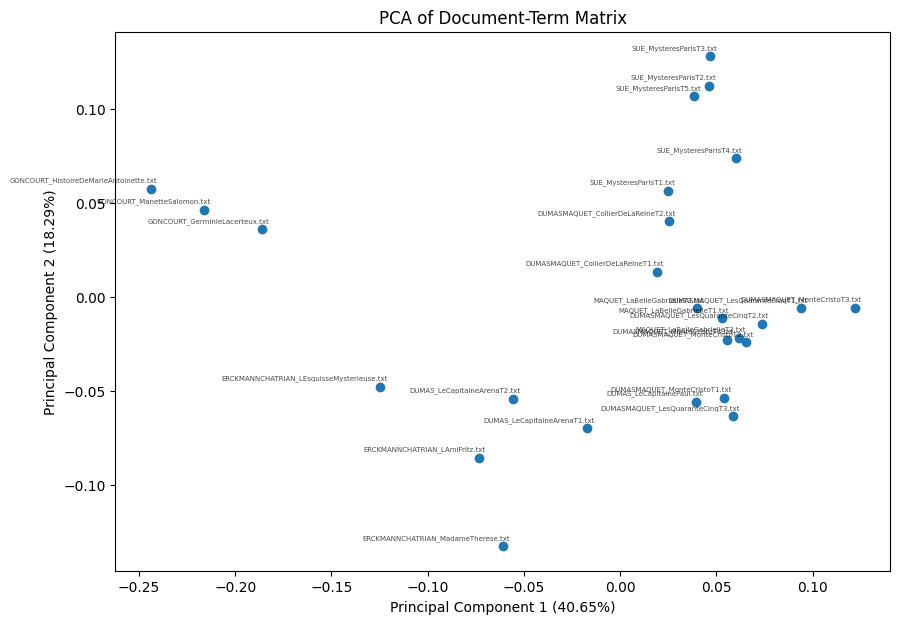

In [ ]:
# Perform PCA on the DTM
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dtm_matrix)

# Calculate the percentage of variance explained by each component
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage

# Plot PCA result with labels and explained variance
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1])

# Adding the explained variance to axis labels
plt.xlabel(f"Principal Component 1 ({explained_variance[0]:.2f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]:.2f}%)")
plt.title("PCA of Document-Term Matrix")

# Add file names as labels for each point
for i, filename in enumerate(filtered_file_names):
    plt.annotate(
        filename,
        (pca_result[i, 0], pca_result[i, 1]),
        textcoords="offset points",
        xytext=(5, 5),  # Offset label to avoid overlap with the point
        ha="right",
        fontsize=5,     # Adjust font size for readability
        alpha=0.7       # Slight transparency for better readability - set up according to your preferences
    )

plt.show()


If we used a naming following the stylo package convention (in R), we can use this scrit to display differently each texts according to their (alleged) author.

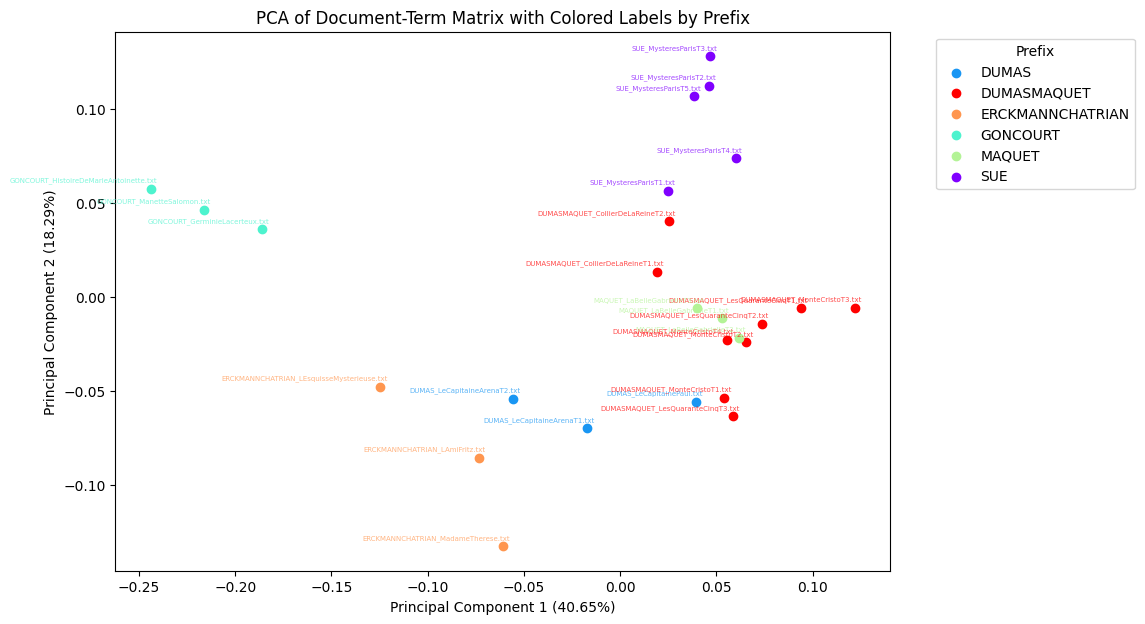

In [ ]:
# Extract prefixes from filtered filenames
prefixes = [filename.split("_")[0] for filename in filtered_file_names]


# Get unique prefixes and assign each a unique color
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))  # Generate colors from a colormap
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

# Plot PCA result with colored labels based on prefix
plt.figure(figsize=(10, 7))
for i, (x, y) in enumerate(pca_result):
    prefix = prefixes[i]
    plt.scatter(x, y, color=color_map[prefix], label=prefix if i == prefixes.index(prefix) else "")  # Show label in legend once
    plt.annotate(
        file_names[i],
        (x, y),
        textcoords="offset points",
        xytext=(5, 5),  # Offset label to avoid overlap with the point
        ha="right",
        fontsize=5,     # Adjust font size for readability
        alpha=0.7,      # Slight transparency for better readability
        color=color_map[prefix]  # Color based on prefix
    )

# Adding the explained variance to axis labels
plt.xlabel(f"Principal Component 1 ({explained_variance[0]:.2f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]:.2f}%)")
plt.title("PCA of Document-Term Matrix with Colored Labels by Prefix")

# Create a legend to show which color corresponds to which prefix
plt.legend(title="Prefix", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


## Analyzing contributions

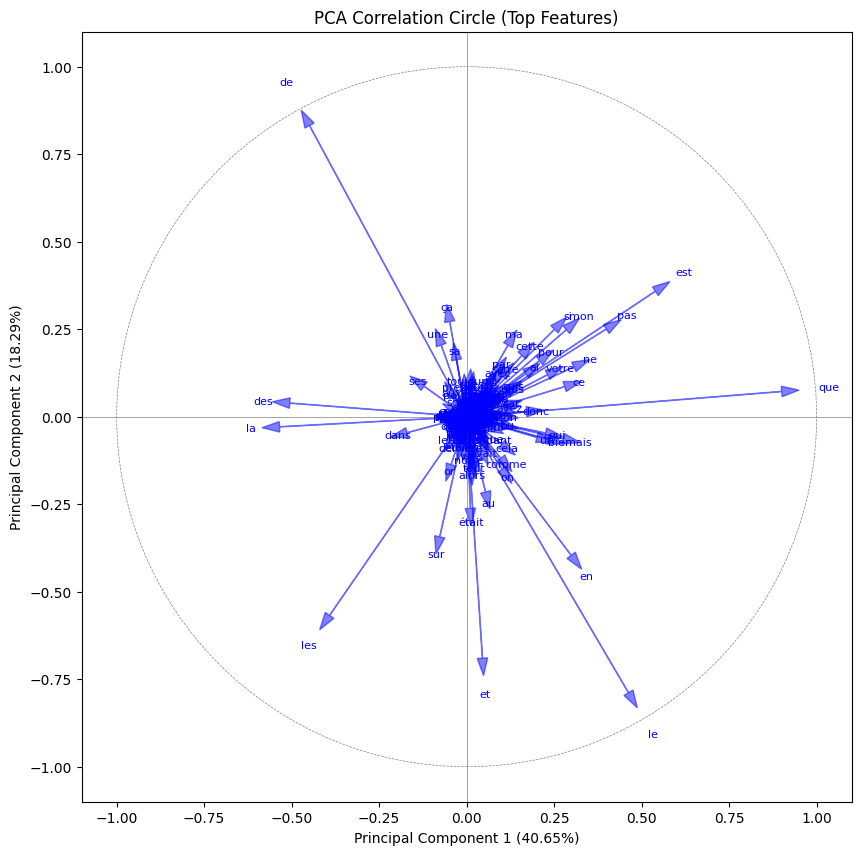

In [ ]:
# Define feature names if not already defined
feature_names = vectorizer.get_feature_names_out()

# Define loadings from the PCA model
loadings = pca.components_  # Loadings represent the contribution of each feature

# Calculate a scaling factor based on the maximum arrow length
max_loading = np.max(np.abs(loadings[:2]))  # Get the max loading for the first two components
scaling_factor = 0.9 / max_loading  # Scale arrows to fit within the unit circle


plt.figure(figsize=(10, 10))
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)

# Plot the unit circle
circle = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--', linewidth=0.5)
plt.gca().add_artist(circle)

# Plot each feature as an arrow, scaled to fit within the circle
for i in range(len(feature_names)):
    plt.arrow(0, 0,
              loadings[0, i] * scaling_factor,
              loadings[1, i] * scaling_factor,
              color='b', alpha=0.5, head_width=0.03, head_length=0.05)
    plt.text(loadings[0, i] * scaling_factor * 1.15,
             loadings[1, i] * scaling_factor * 1.15,
             feature_names[i],
             color='blue', ha='center', va='center', fontsize=8)

# Configure plot aesthetics
plt.xlabel(f"Principal Component 1 ({explained_variance[0]:.2f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]:.2f}%)")
plt.title("PCA Correlation Circle (Top Features)")
plt.grid(False)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()



## Filtering authors

6 authors is too much... Let's deal with it, by using a good number of authors, and passing the text to attribute as supplementary.

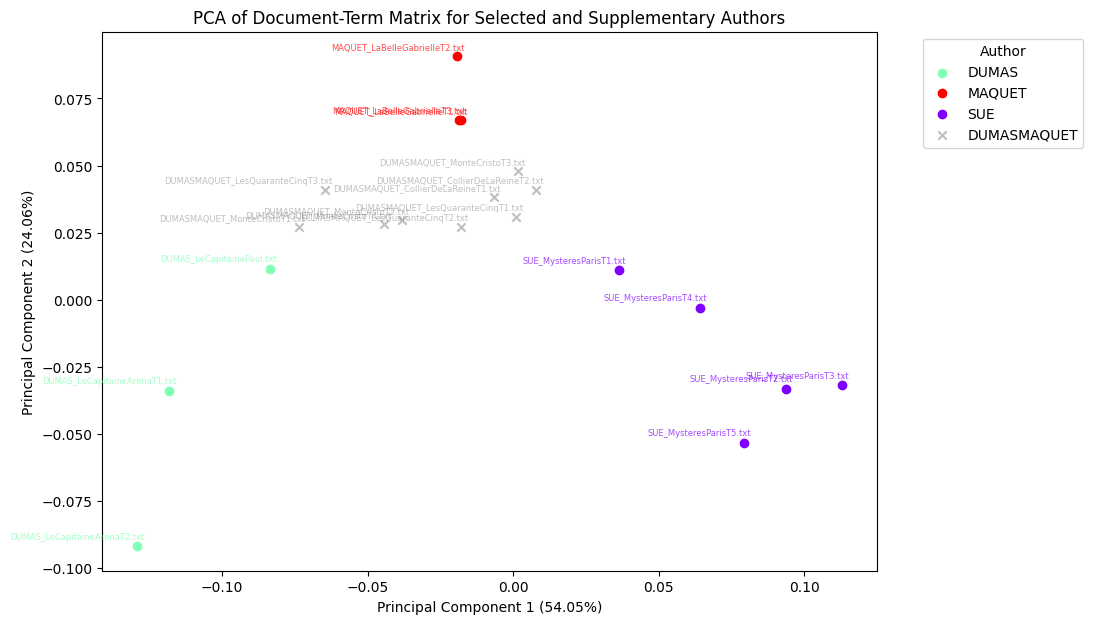

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def pca_by_authors(selected_authors, supplementary_authors, filtered_file_names, data_matrix, explained_variance):
    """
    Filters the data matrix to display PCA results for specified main authors
    and projects supplementary authors onto the precomputed PCA space.

    Parameters:
    - selected_authors (list of str): List of main authors to include in PCA computation.
    - supplementary_authors (list of str): List of supplementary authors to project onto PCA.
    - filtered_file_names (list of str): List of all filenames.
    - data_matrix (ndarray): The original data matrix (e.g., TF-IDF matrix).
    - explained_variance (list or ndarray): Percentage of variance explained by each PCA component.
    """
    # Step 1: Filter filenames and data matrix for selected main authors
    selected_indices = [i for i, filename in enumerate(filtered_file_names)
                        if filename.split("_")[0] in selected_authors]
    supplementary_indices = [i for i, filename in enumerate(filtered_file_names)
                             if filename.split("_")[0] in supplementary_authors]

    # Separate data matrix for main authors and supplementary authors
    selected_data = data_matrix[selected_indices]
    supplementary_data = data_matrix[supplementary_indices]

    selected_file_names = [filtered_file_names[i] for i in selected_indices]
    supplementary_file_names = [filtered_file_names[i] for i in supplementary_indices]

    selected_prefixes = [filename.split("_")[0] for filename in selected_file_names]
    supplementary_prefixes = [filename.split("_")[0] for filename in supplementary_file_names]

    # Step 2: Perform PCA on the data of the selected authors
    pca = PCA(n_components=2)
    selected_pca_result = pca.fit_transform(selected_data)

    # Step 3: Project the supplementary authors' data onto the precomputed PCA space
    supplementary_pca_result = pca.transform(supplementary_data)

    # Step 4: Generate unique colors for each main author
    unique_authors = list(set(selected_prefixes))
    colors = cm.rainbow(np.linspace(0, 1, len(unique_authors)))
    color_map = {author: color for author, color in zip(unique_authors, colors)}

    # Step 5: Plot the PCA result for the selected authors
    plt.figure(figsize=(10, 7))
    for i, (x, y) in enumerate(selected_pca_result):
        author_prefix = selected_prefixes[i]
        plt.scatter(x, y, color=color_map[author_prefix],
                    label=author_prefix if i == selected_prefixes.index(author_prefix) else "")
        plt.annotate(
            selected_file_names[i],
            (x, y),
            textcoords="offset points",
            xytext=(5, 5),
            ha="right",
            fontsize=6,
            alpha=0.7,
            color=color_map[author_prefix]
        )

    # Step 6: Plot the supplementary authors with a different marker or transparency
    for i, (x, y) in enumerate(supplementary_pca_result):
        author_prefix = supplementary_prefixes[i]
        plt.scatter(x, y, color='gray', marker='x', alpha=0.5,
                    label=author_prefix if i == supplementary_prefixes.index(author_prefix) else "")
        plt.annotate(
            supplementary_file_names[i],
            (x, y),
            textcoords="offset points",
            xytext=(5, 5),
            ha="right",
            fontsize=6,
            alpha=0.5,
            color='gray'
        )

    # Step 7: Adding explained variance to axis labels
    plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)")
    plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1] * 100:.2f}%)")
    plt.title("PCA of Document-Term Matrix for Selected and Supplementary Authors")

    # Step 8: Create a legend to show which color corresponds to which main author
    plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Example usage:
pca_by_authors(
    selected_authors=["DUMAS", "MAQUET", "SUE"],
    supplementary_authors=["DUMASMAQUET"],
    filtered_file_names=filtered_file_names,
    data_matrix=dtm_matrix,
    explained_variance=explained_variance
)


## T-SNE

## Regular use (without assuming the prefixing 'à la stylo')

Number of documents (samples): 26


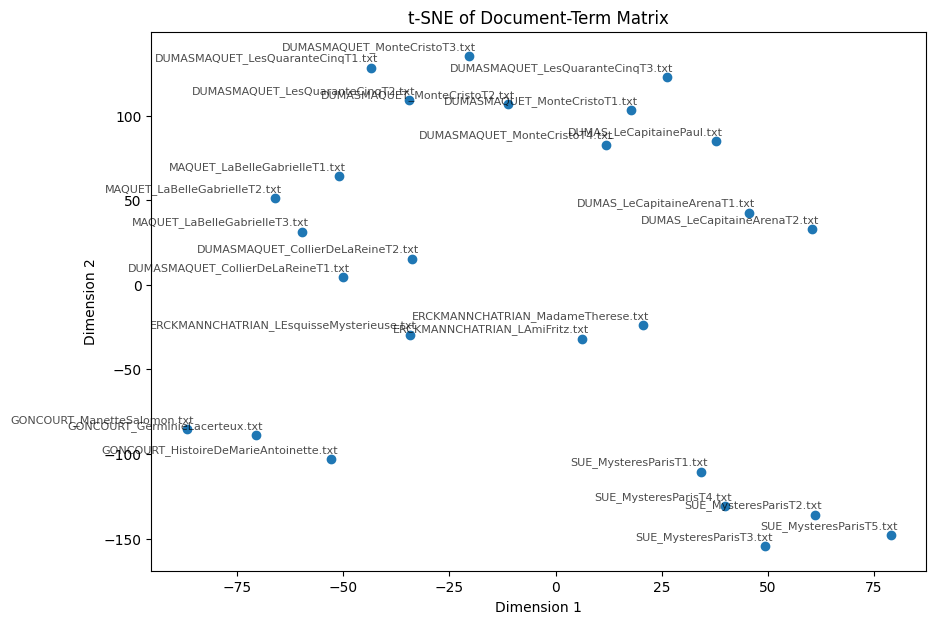

In [ ]:
# Check the number of samples
num_samples = dtm_matrix.shape[0]
print(f"Number of documents (samples): {num_samples}")

# Set perplexity to a smaller value, such as min(5, num_samples - 1) if fewer than 5 samples are present - it will avoid some errors (add messages to handle this better maybe ?)
adjusted_perplexity = 6

## t-SNE with adjusted perplexity
tsne = TSNE(n_components=2, perplexity=adjusted_perplexity, max_iter=1000)
tsne_result = tsne.fit_transform(dtm_matrix)

# Plot t-SNE result with file names as labels
plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])

plt.title("t-SNE of Document-Term Matrix")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Add file names as labels for each point
for i, filename in enumerate(filtered_file_names):
    plt.annotate(
        filename,
        (tsne_result[i, 0], tsne_result[i, 1]),
        textcoords="offset points",
        xytext=(5, 5),  # Offset to avoid overlap with the point
        ha="right",
        fontsize=8,     # Adjust font size for readability
        alpha=0.7       # Slight transparency for better readability
    )

plt.show()


## Coloring by label

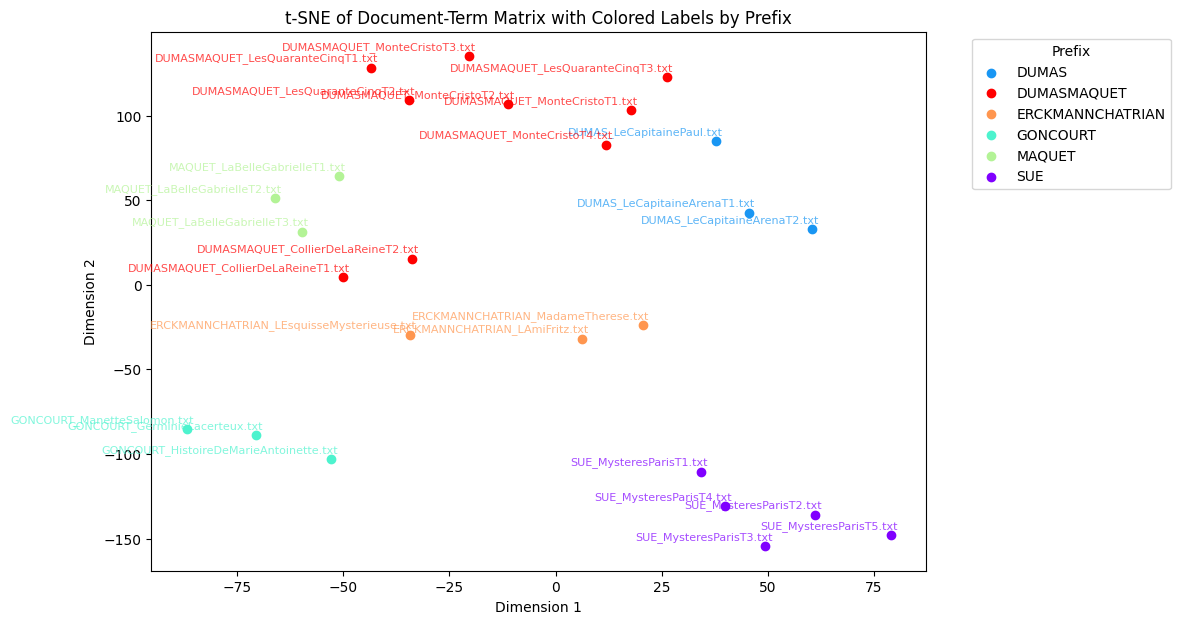

In [ ]:
# Extract prefixes from filenames
prefixes = [filename.split("_")[0] for filename in filtered_file_names]

# Get unique prefixes and assign each a unique color
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))  # Generate colors from a colormap
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

# Plot t-SNE result with colored labels based on prefix
plt.figure(figsize=(10, 7))
for i, (x, y) in enumerate(tsne_result):
    prefix = prefixes[i]
    plt.scatter(x, y, color=color_map[prefix], label=prefix if i == prefixes.index(prefix) else "")  # Show label in legend once
    plt.annotate(
        file_names[i],
        (x, y),
        textcoords="offset points",
        xytext=(5, 5),  # Offset label to avoid overlap with the point
        ha="right",
        fontsize=8,     # Adjust font size for readability
        alpha=0.7,      # Slight transparency for better readability
        color=color_map[prefix]  # Color based on prefix
    )

# Add plot title and labels
plt.title("t-SNE of Document-Term Matrix with Colored Labels by Prefix")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Create a legend to show which color corresponds to which prefix
plt.legend(title="Prefix", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


## Interpretation of the t-SNE

t-SNE is a non-linear dimensionality reduction technique, and it does not directly provide feature importance scores like linear models or tree-based algorithms do. A shortcut can be the following:  by correlating the original features (our chosen terms or features in the DTM) with the resulting t-SNE dimensions, we can get an idea of which features influence the positions of the points in the 2D space.


Top 10 positive features correlated with t-SNE Dimension 1:
selon      0.611918
ensuite    0.618354
encore     0.621552
avant      0.657186
quoique    0.664893
aussi      0.669073
après      0.685609
enfin      0.708752
lorsque    0.711618
pendant    0.779007
Name: TSNE_1, dtype: float64

Top 10 negative features correlated with t-SNE Dimension 1:
quand         -0.502814
des           -0.498131
toutes        -0.450891
autour        -0.429155
là            -0.375139
précisément   -0.374702
eussiez       -0.374321
ses           -0.371412
alliez        -0.368504
eut           -0.349676
Name: TSNE_1, dtype: float64

Top 10 positive features correlated with t-SNE Dimension 2:
eut          0.649090
celui        0.649854
fût          0.654706
eût          0.656431
outre        0.672920
eussent      0.708564
quelque      0.738806
lequel       0.776246
le           0.784823
cependant    0.942827
Name: TSNE_2, dtype: float64

Top 10 negative features correlated with t-SNE Dimension 2:
pourtant 

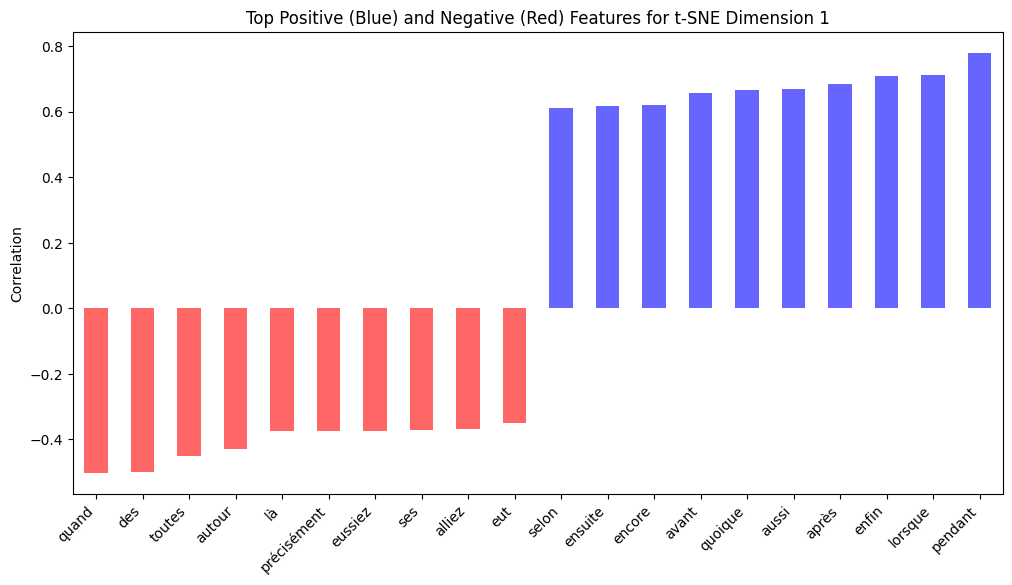

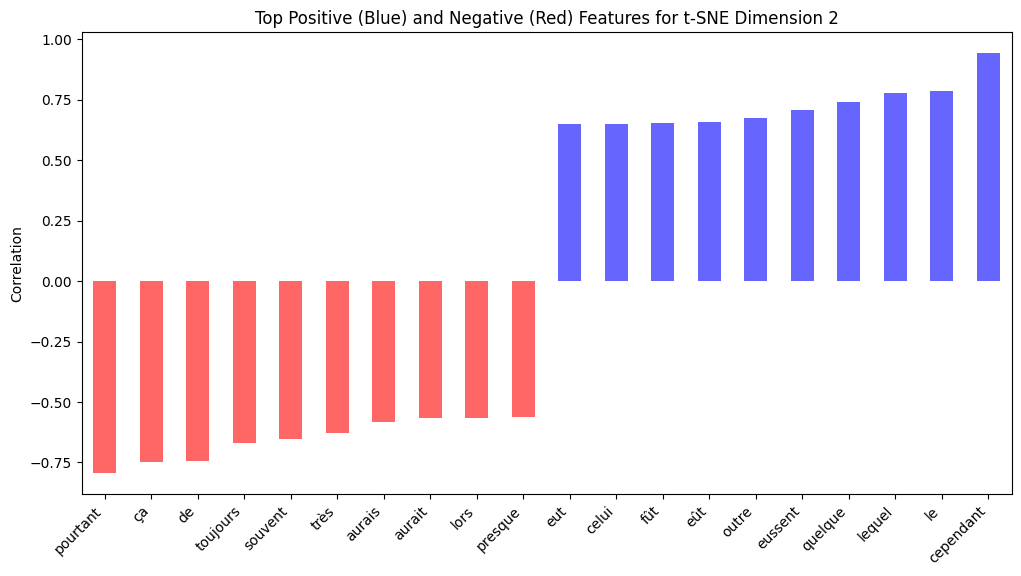

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Ensure dtm_matrix is a DataFrame with correct feature names
if not isinstance(dtm_matrix, pd.DataFrame):
    feature_names = vectorizer.get_feature_names_out()  # Replace 'vectorizer' with your actual vectorizer instance
    dtm_df = pd.DataFrame(dtm_matrix, columns=feature_names)
else:
    dtm_df = dtm_matrix  # It's already a DataFrame with columns

# Create a DataFrame from the t-SNE results
tsne_df = pd.DataFrame(tsne_result, columns=['TSNE_1', 'TSNE_2'])

# Concatenate the DTM features with the t-SNE results
merged_df = pd.concat([dtm_df, tsne_df], axis=1)

# Compute correlation between DTM features and t-SNE components
correlation_matrix = merged_df.corr()

# Extract correlations of each feature with the t-SNE dimensions
tsne_feature_correlation = correlation_matrix[['TSNE_1', 'TSNE_2']].drop(['TSNE_1', 'TSNE_2'])

# Function to get top 10 positive and top 10 negative features for each dimension
def get_top_positive_negative(correlations, dimension):
    # Sort correlations for the specified dimension
    sorted_corr = correlations[dimension].sort_values()
    # Get top 10 negative and top 10 positive correlations
    top_negative = sorted_corr.head(10)
    top_positive = sorted_corr.tail(10)
    return top_positive, top_negative

# Get top positive and negative features for t-SNE Dimension 1
top_positive_tsne1, top_negative_tsne1 = get_top_positive_negative(tsne_feature_correlation, 'TSNE_1')

# Get top positive and negative features for t-SNE Dimension 2
top_positive_tsne2, top_negative_tsne2 = get_top_positive_negative(tsne_feature_correlation, 'TSNE_2')

# Print results
print("\nTop 10 positive features correlated with t-SNE Dimension 1:")
print(top_positive_tsne1)

print("\nTop 10 negative features correlated with t-SNE Dimension 1:")
print(top_negative_tsne1)

print("\nTop 10 positive features correlated with t-SNE Dimension 2:")
print(top_positive_tsne2)

print("\nTop 10 negative features correlated with t-SNE Dimension 2:")
print(top_negative_tsne2)

# Plot the top positive and negative correlated features
def plot_top_features(top_positive, top_negative, dimension):
    plt.figure(figsize=(12, 6))
    top_features = pd.concat([top_negative, top_positive])
    colors = ['red'] * len(top_negative) + ['blue'] * len(top_positive)
    top_features.plot(kind='bar', color=colors, alpha=0.6)
    plt.title(f"Top Positive (Blue) and Negative (Red) Features for {dimension}")
    plt.ylabel("Correlation")
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Plot for t-SNE Dimension 1
plot_top_features(top_positive_tsne1, top_negative_tsne1, 't-SNE Dimension 1')

# Plot for t-SNE Dimension 2
plot_top_features(top_positive_tsne2, top_negative_tsne2, 't-SNE Dimension 2')



## Multi dimensional scaling

### Metric MDS

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Stress du MDS : 0.0037
Très bon ajustement (le MDS préserve bien les distances).


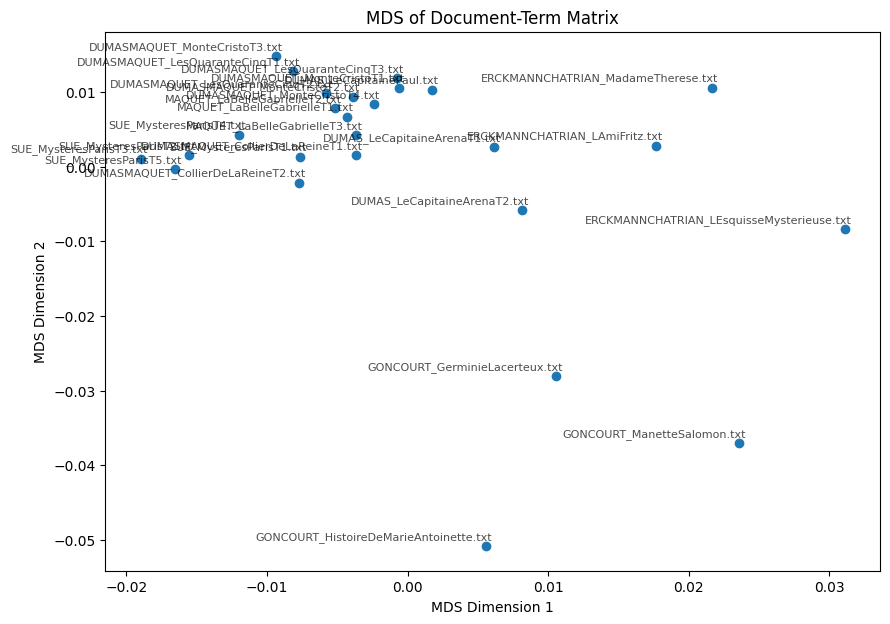

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Calculer la matrice des distances (ici avec la distance cosinus)
distance_matrix = pdist(dtm_matrix, 'cosine')

# Effectuer le MDS avec la matrice de distances pré-calculée
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_result = mds.fit_transform(squareform(distance_matrix))

# Calculer le stress
stress = mds.stress_

# Afficher le stress avec une interprétation
print(f"Stress du MDS : {stress:.4f}")
if stress < 0.05:
    print("Très bon ajustement (le MDS préserve bien les distances).")
elif stress < 0.1:
    print("Bon ajustement (le MDS préserve assez bien les distances).")
elif stress < 0.2:
    print("Ajustement moyen (quelques distorsions dans la préservation des distances).")
else:
    print("Ajustement faible (le MDS ne préserve pas bien les distances).")

# Visualiser le résultat du MDS
plt.figure(figsize=(10, 7))
plt.scatter(mds_result[:, 0], mds_result[:, 1])

plt.title("MDS of Document-Term Matrix")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")

# Ajouter les noms des fichiers comme labels pour chaque point
for i, filename in enumerate(filtered_file_names):
    plt.annotate(
        filename,
        (mds_result[i, 0], mds_result[i, 1]),
        textcoords="offset points",
        xytext=(5, 5),  # Décalage du label pour éviter le chevauchement
        ha="right",
        fontsize=8,
        alpha=0.7
    )

plt.show()


#### Coloring by label

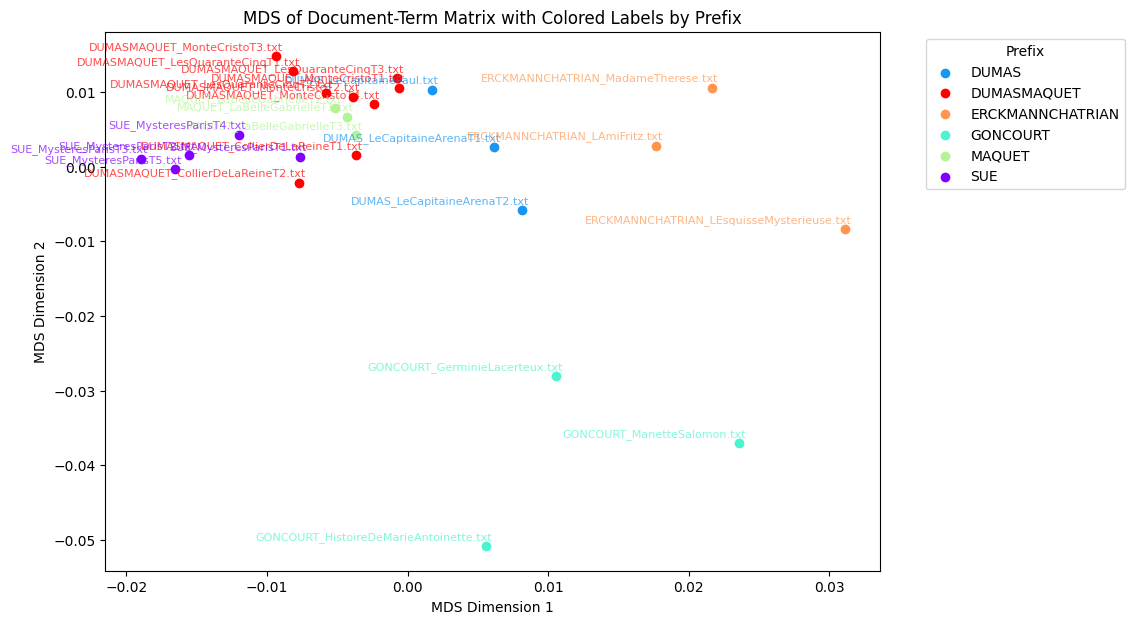

In [ ]:
# Extract prefixes from filenames, ensuring alignment with mds_result
prefixes = [filename.split("_")[0] for filename in filtered_file_names]  # Use file_names instead of filtered_file_names

# Get unique prefixes and assign each a unique color
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))  # Generate colors from a colormap
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

# Plot MDS result with colored labels based on prefix
plt.figure(figsize=(10, 7))
for i, (x, y) in enumerate(mds_result):
    # Ensure i is within the bounds of prefixes
    if i < len(prefixes):
        prefix = prefixes[i]
        plt.scatter(x, y, color=color_map[prefix], label=prefix if i == prefixes.index(prefix) else "")  # Show label in legend once
        plt.annotate(
            file_names[i],
            (x, y),
            textcoords="offset points",
            xytext=(5, 5),  # Offset label to avoid overlap with the point
            ha="right",
            fontsize=8,     # Adjust font size for readability
            alpha=0.7,      # Slight transparency for better readability
            color=color_map[prefix]  # Color based on prefix
        )

# Add plot title and labels
plt.title("MDS of Document-Term Matrix with Colored Labels by Prefix")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")

# Create a legend to show which color corresponds to which prefix
plt.legend(title="Prefix", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

#### Interpreting the metric MDS

For Multidimensional Scaling (MDS), understanding which features contribute most to the positions of the points is also not straightforward. MDS operates on a distance matrix (in your case, based on cosine distances between documents) rather than directly on the features. However, we can approximate the influence of features by analyzing how they correlate with the MDS dimensions, similar to what we did with t-SNE.


Top 10 positive features correlated with MDS Dimension 1:
jusqu       0.563733
bref        0.581698
entre       0.592935
dehors      0.607421
dans        0.625009
des         0.668045
derrière    0.684721
sur         0.724047
leurs       0.791831
les         0.868586
Name: MDS_1, dtype: float64

Top 10 negative features correlated with MDS Dimension 1:
si      -0.917717
être    -0.867342
peut    -0.813305
moins   -0.808825
pour    -0.808330
ici     -0.801128
votre   -0.798846
assez   -0.795970
vos     -0.795361
été     -0.792409
Name: MDS_1, dtype: float64

Top 10 positive features correlated with MDS Dimension 2:
celui    0.682087
êtes     0.685524
car      0.685725
le       0.753959
ou       0.754201
donc     0.780404
en       0.804164
bien     0.807121
que      0.816292
mais     0.883521
Name: MDS_2, dtype: float64

Top 10 negative features correlated with MDS Dimension 2:
de           -0.810309
des          -0.760227
aux          -0.695182
ses          -0.649164
la           -0.59

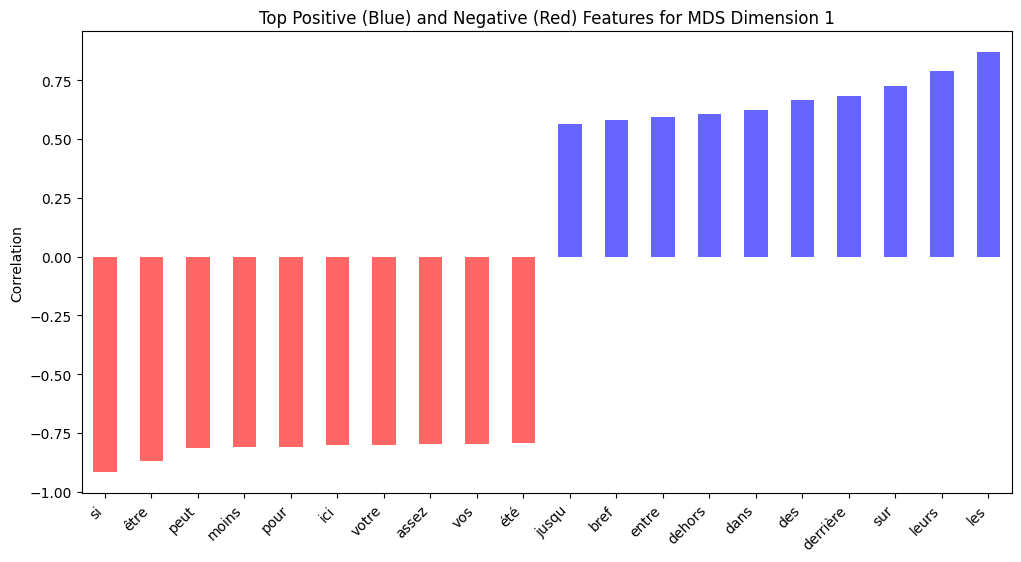

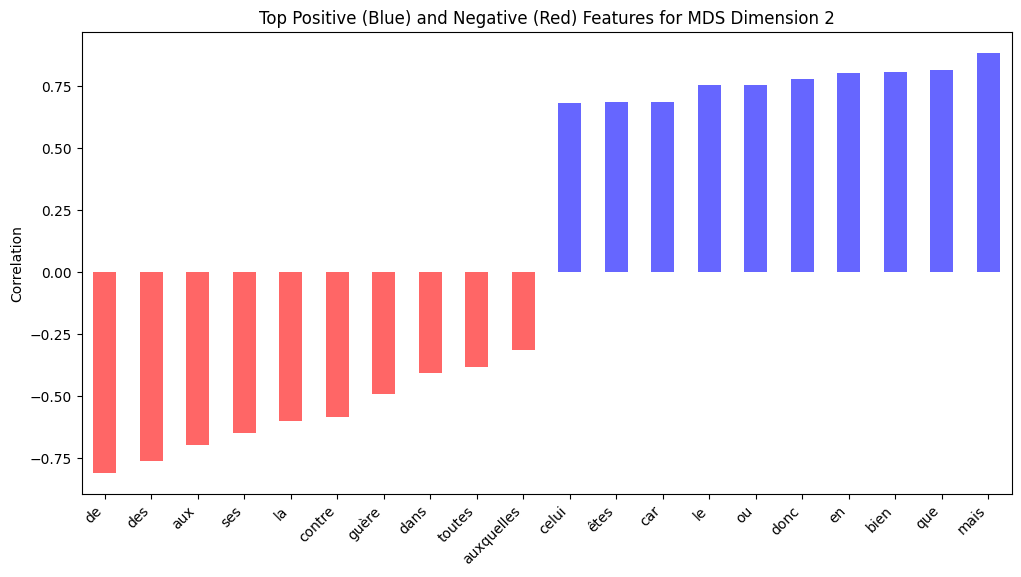

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Ensure dtm_matrix is a DataFrame with correct feature names
if not isinstance(dtm_matrix, pd.DataFrame):
    feature_names = vectorizer.get_feature_names_out()  # Replace 'vectorizer' with your actual vectorizer instance
    dtm_df = pd.DataFrame(dtm_matrix, columns=feature_names)
else:
    dtm_df = dtm_matrix  # It's already a DataFrame with columns

# Create a DataFrame from the MDS results
mds_df = pd.DataFrame(mds_result, columns=['MDS_1', 'MDS_2'])

# Concatenate the DTM features with the MDS results
merged_df = pd.concat([dtm_df, mds_df], axis=1)

# Compute correlation between DTM features and MDS components
correlation_matrix = merged_df.corr()

# Extract correlations of each feature with the MDS dimensions
mds_feature_correlation = correlation_matrix[['MDS_1', 'MDS_2']].drop(['MDS_1', 'MDS_2'])

def get_top_positive_negative(correlations, dimension):
    sorted_corr = correlations[dimension].sort_values()
    top_negative = sorted_corr.head(10)
    top_positive = sorted_corr.tail(10)
    return top_positive, top_negative

# Get top positive and negative features for MDS Dimension 1
top_positive_mds1, top_negative_mds1 = get_top_positive_negative(mds_feature_correlation, 'MDS_1')

# Get top positive and negative features for MDS Dimension 2
top_positive_mds2, top_negative_mds2 = get_top_positive_negative(mds_feature_correlation, 'MDS_2')

print("\nTop 10 positive features correlated with MDS Dimension 1:")
print(top_positive_mds1)
print("\nTop 10 negative features correlated with MDS Dimension 1:")
print(top_negative_mds1)
print("\nTop 10 positive features correlated with MDS Dimension 2:")
print(top_positive_mds2)
print("\nTop 10 negative features correlated with MDS Dimension 2:")
print(top_negative_mds2)

def plot_top_features(top_positive, top_negative, dimension):
    plt.figure(figsize=(12, 6))
    top_features = pd.concat([top_negative, top_positive])
    colors = ['red'] * len(top_negative) + ['blue'] * len(top_positive)
    top_features.plot(kind='bar', color=colors, alpha=0.6)
    plt.title(f"Top Positive (Blue) and Negative (Red) Features for {dimension}")
    plt.ylabel("Correlation")
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_top_features(top_positive_mds1, top_negative_mds1, 'MDS Dimension 1')
plot_top_features(top_positive_mds2, top_negative_mds2, 'MDS Dimension 2')


### Non Metric MDS

### Isomap

Trustworthiness : 0.9114
Très bon ajustement (les relations de voisinage sont bien conservées).


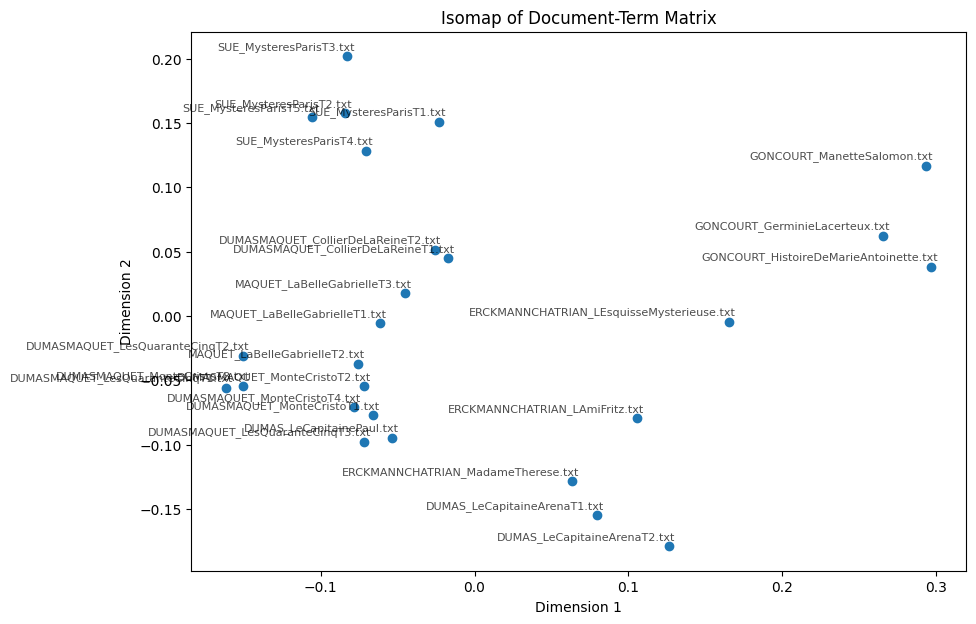

In [ ]:
# Définir le nombre de voisins à utiliser pour Isomap
n_neighbors = 6  # Ajustez ce nombre selon votre jeu de données

# Calculer Isomap avec le nombre de voisins spécifié
isomap = Isomap(n_neighbors=n_neighbors, n_components=2)
isomap_result = isomap.fit_transform(dtm_matrix)

# Calculer la métrique de confiance (trustworthiness)
trust_score = trustworthiness(dtm_matrix, isomap_result, n_neighbors=n_neighbors)

# Afficher le score de trustworthiness avec une interprétation
print(f"Trustworthiness : {trust_score:.4f}")
if trust_score > 0.9:
    print("Très bon ajustement (les relations de voisinage sont bien conservées).")
elif trust_score > 0.8:
    print("Bon ajustement (les relations de voisinage sont assez bien conservées).")
elif trust_score > 0.7:
    print("Ajustement moyen (certaines relations de voisinage sont perdues).")
else:
    print("Ajustement faible (les relations de voisinage ne sont pas bien conservées).")

# Visualiser le résultat d'Isomap
plt.figure(figsize=(10, 7))
plt.scatter(isomap_result[:, 0], isomap_result[:, 1])

plt.title("Isomap of Document-Term Matrix")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Ajouter les noms des fichiers comme labels pour chaque point
for i, filename in enumerate(filtered_file_names):
    plt.annotate(
        filename,
        (isomap_result[i, 0], isomap_result[i, 1]),
        textcoords="offset points",
        xytext=(5, 5),  # Décalage du label pour éviter le chevauchement
        ha="right",
        fontsize=8,
        alpha=0.7
    )

plt.show()


#### Coloring by labels

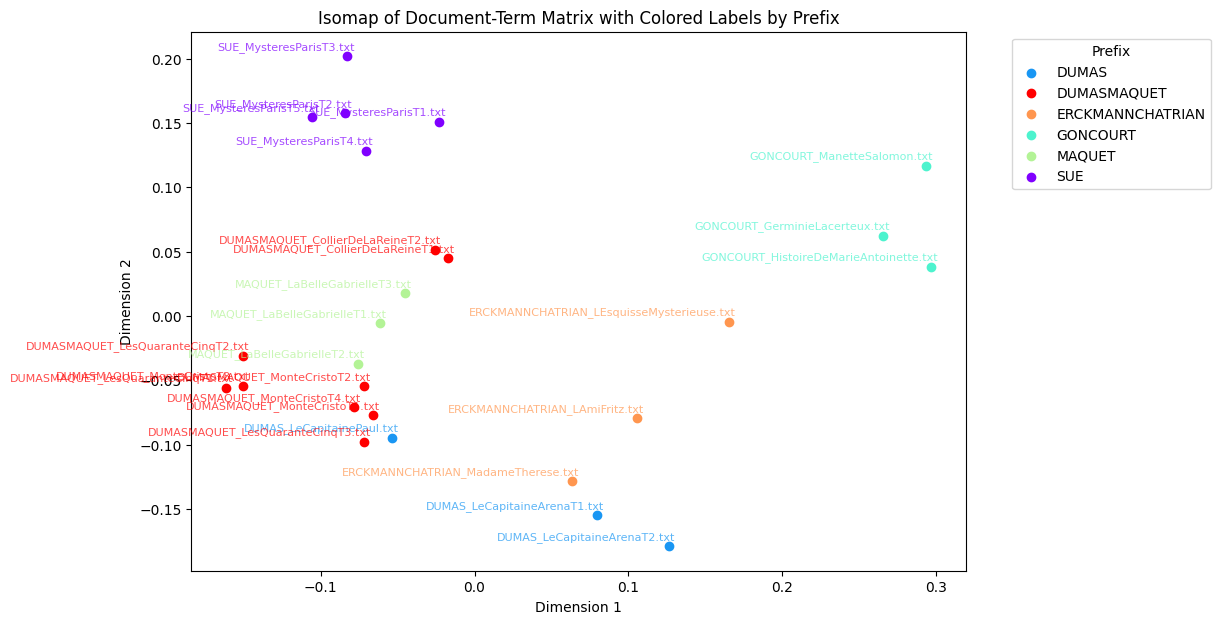

In [ ]:
# Extract prefixes from filenames, ensuring alignment with isomap_result
prefixes = [filename.split("_")[0] for filename in filtered_file_names]  # Use file_names instead of filtered_file_names

# Get unique prefixes and assign each a unique color
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))  # Generate colors from a colormap
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

# Plot Isomap result with colored labels based on prefix
plt.figure(figsize=(10, 7))
for i, (x, y) in enumerate(isomap_result):
    # Ensure i is within the bounds of prefixes
    if i < len(prefixes):
        prefix = prefixes[i]
        plt.scatter(x, y, color=color_map[prefix], label=prefix if i == prefixes.index(prefix) else "")  # Show label in legend once
        plt.annotate(
            file_names[i],  # Use file_names consistently
            (x, y),
            textcoords="offset points",
            xytext=(5, 5),  # Offset label to avoid overlap with the point
            ha="right",
            fontsize=8,     # Adjust font size for readability
            alpha=0.7,      # Slight transparency for better readability
            color=color_map[prefix]  # Color based on prefix
        )

# Add plot title and labels
plt.title("Isomap of Document-Term Matrix with Colored Labels by Prefix")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Create a legend to show which color corresponds to each prefix
plt.legend(title="Prefix", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

#### Interpretation of the Isomap


Top 10 positive features correlated with Isomap Dimension 1:
eurent    0.403960
toutes    0.415656
autour    0.512852
de        0.529556
leurs     0.553526
dans      0.561626
ses       0.587805
les       0.636069
la        0.641182
des       0.823785
Name: Isomap_1, dtype: float64

Top 10 negative features correlated with Isomap Dimension 1:
que     -0.928679
mais    -0.920854
votre   -0.900580
ce      -0.878019
suis    -0.875490
donc    -0.873254
êtes    -0.834800
est     -0.827240
vos     -0.821237
ai      -0.817834
Name: Isomap_1, dtype: float64

Top 10 positive features correlated with Isomap Dimension 2:
certains    0.551854
presque     0.582114
ici         0.607714
oui         0.652711
très        0.664004
de          0.664408
ça          0.685857
toujours    0.686177
pourtant    0.722186
souvent     0.735148
Name: Isomap_2, dtype: float64

Top 10 negative features correlated with Isomap Dimension 2:
chacun      -0.807874
autre       -0.750940
avaient     -0.745112
et          -

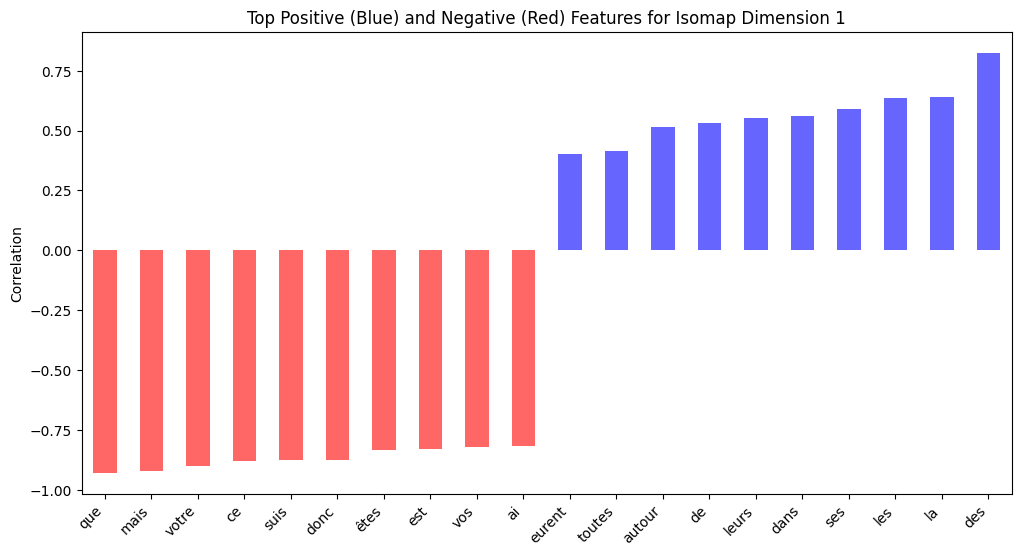

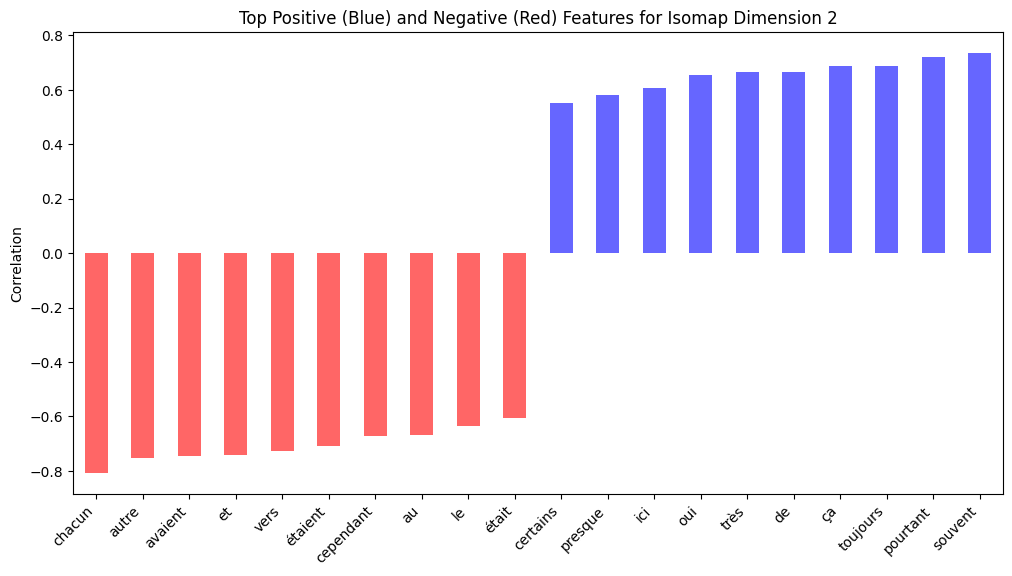

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Ensure dtm_matrix is a DataFrame with correct feature names
if not isinstance(dtm_matrix, pd.DataFrame):
    feature_names = vectorizer.get_feature_names_out()  # Replace 'vectorizer' with your actual vectorizer instance
    dtm_df = pd.DataFrame(dtm_matrix, columns=feature_names)
else:
    dtm_df = dtm_matrix  # It's already a DataFrame with columns

# Create a DataFrame from the Isomap results
isomap_df = pd.DataFrame(isomap_result, columns=['Isomap_1', 'Isomap_2'])

# Concatenate the DTM features with the Isomap results
merged_df = pd.concat([dtm_df, isomap_df], axis=1)

# Compute correlation between DTM features and Isomap components
correlation_matrix = merged_df.corr()

# Extract correlations of each feature with the Isomap dimensions
isomap_feature_correlation = correlation_matrix[['Isomap_1', 'Isomap_2']].drop(['Isomap_1', 'Isomap_2'])

# Function to get top 10 positive and top 10 negative features for each dimension
def get_top_positive_negative(correlations, dimension):
    # Sort correlations for the specified dimension
    sorted_corr = correlations[dimension].sort_values()
    # Get top 10 negative and top 10 positive correlations
    top_negative = sorted_corr.head(10)
    top_positive = sorted_corr.tail(10)
    return top_positive, top_negative

# Get top positive and negative features for Isomap Dimension 1
top_positive_isomap1, top_negative_isomap1 = get_top_positive_negative(isomap_feature_correlation, 'Isomap_1')

# Get top positive and negative features for Isomap Dimension 2
top_positive_isomap2, top_negative_isomap2 = get_top_positive_negative(isomap_feature_correlation, 'Isomap_2')

# Print results
print("\nTop 10 positive features correlated with Isomap Dimension 1:")
print(top_positive_isomap1)

print("\nTop 10 negative features correlated with Isomap Dimension 1:")
print(top_negative_isomap1)

print("\nTop 10 positive features correlated with Isomap Dimension 2:")
print(top_positive_isomap2)

print("\nTop 10 negative features correlated with Isomap Dimension 2:")
print(top_negative_isomap2)

# Plot the top positive and negative correlated features
def plot_top_features(top_positive, top_negative, dimension):
    plt.figure(figsize=(12, 6))
    top_features = pd.concat([top_negative, top_positive])
    colors = ['red'] * len(top_negative) + ['blue'] * len(top_positive)
    top_features.plot(kind='bar', color=colors, alpha=0.6)
    plt.title(f"Top Positive (Blue) and Negative (Red) Features for {dimension}")
    plt.ylabel("Correlation")
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Plot for Isomap Dimension 1
plot_top_features(top_positive_isomap1, top_negative_isomap1, 'Isomap Dimension 1')

# Plot for Isomap Dimension 2
plot_top_features(top_positive_isomap2, top_negative_isomap2, 'Isomap Dimension 2')


# Clustering

## Hierarchical clustering

### Euclidean distance (just for fun)

Number of documents: 26
Number of labels: 26
Dunn Index: 0.3923


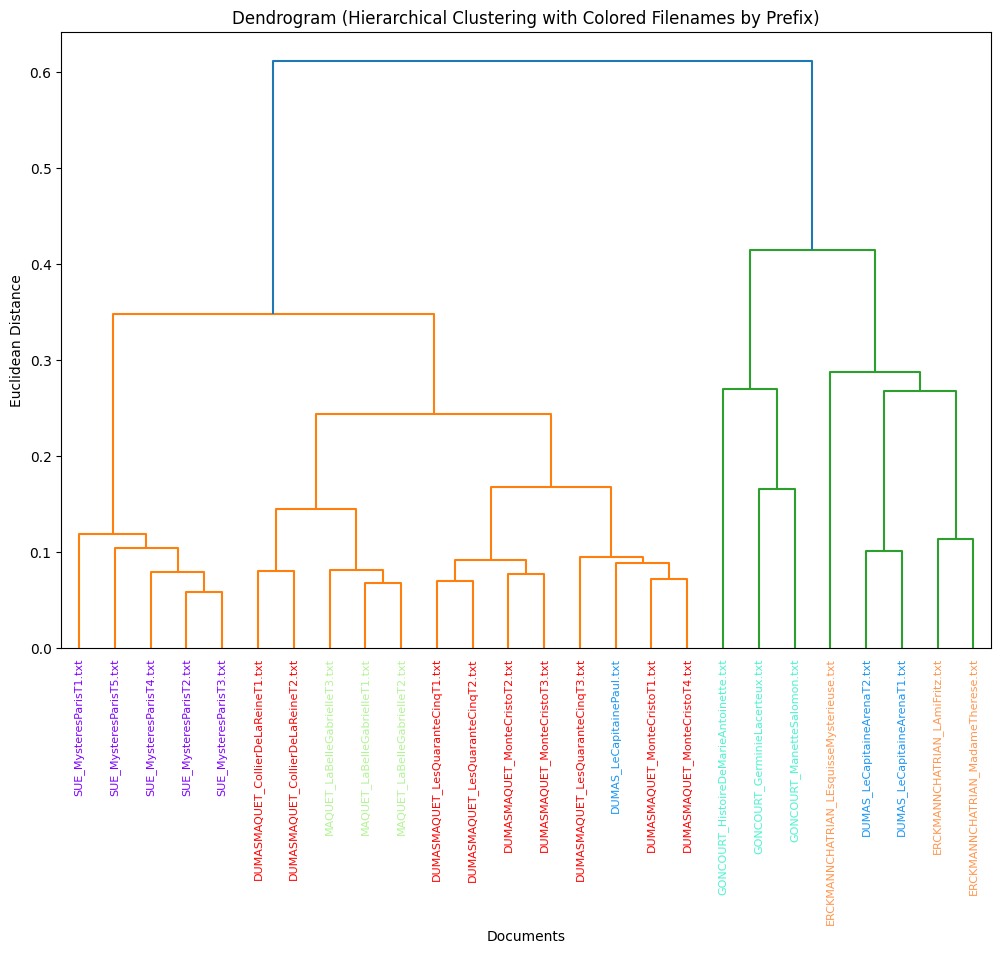

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Étape 1 : Calculer la matrice de distance et effectuer le clustering hiérarchique
distance_matrix = pdist(dtm_matrix, 'euclidean')  # Assurez-vous que dtm_matrix est sous forme de tableau
linkage_matrix = linkage(distance_matrix, 'ward')

# Vérification de l'alignement
num_documents = dtm_matrix.shape[0]
num_labels = len(filtered_file_names)
print(f"Number of documents: {num_documents}")
print(f"Number of labels: {num_labels}")

if num_documents != num_labels:
    print("Mismatch between the number of documents and labels.")
    raise ValueError("The number of documents and labels do not match.")

# Extraire les préfixes des noms de fichiers
prefixes = [filename.split("_")[0] for filename in filtered_file_names]
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

# Étape 2 : Créer les clusters
# Choisissez un seuil pour couper l'arbre hiérarchique et former des clusters
num_clusters = 5  # Ajustez ce nombre en fonction de vos besoins
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Étape 3 : Calculer l'index de Dunn
def calculate_dunn_index(distance_matrix, clusters):
    """
    Calcule l'index de Dunn pour une classification donnée.
    """
    # Convertir la matrice de distances en matrice carrée
    dist_matrix_square = squareform(distance_matrix)

    # Calculer le diamètre maximal (intra-cluster)
    max_intra_distances = []
    for cluster in np.unique(clusters):
        indices = np.where(clusters == cluster)[0]
        if len(indices) > 1:
            intra_distances = dist_matrix_square[np.ix_(indices, indices)]
            max_intra_distances.append(np.max(intra_distances))
        else:
            max_intra_distances.append(0)  # Cas où le cluster a un seul élément
    max_diameter = max(max_intra_distances)

    # Calculer la distance minimale (inter-cluster)
    min_inter_distance = float('inf')
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            if clusters[i] != clusters[j]:
                min_inter_distance = min(min_inter_distance, dist_matrix_square[i, j])

    # Calculer l'index de Dunn
    dunn_index = min_inter_distance / max_diameter if max_diameter > 0 else 0
    return dunn_index

# Calculer et afficher l'index de Dunn
dunn_index = calculate_dunn_index(distance_matrix, clusters)
print(f"Dunn Index: {dunn_index:.4f}")

# Étape 4 : Visualiser le dendrogramme
plt.figure(figsize=(12, 8))
dendro = dendrogram(
    linkage_matrix,
    labels=filtered_file_names,
    leaf_rotation=90,
    leaf_font_size=8,
)
plt.title("Dendrogram (Hierarchical Clustering with Colored Filenames by Prefix)")
plt.xlabel("Documents")
plt.ylabel("Euclidean Distance")

# Appliquer des couleurs aux étiquettes en fonction du préfixe
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for label in x_labels:
    filename = label.get_text()
    prefix = filename.split("_")[0]
    label.set_color(color_map[prefix])

plt.show()


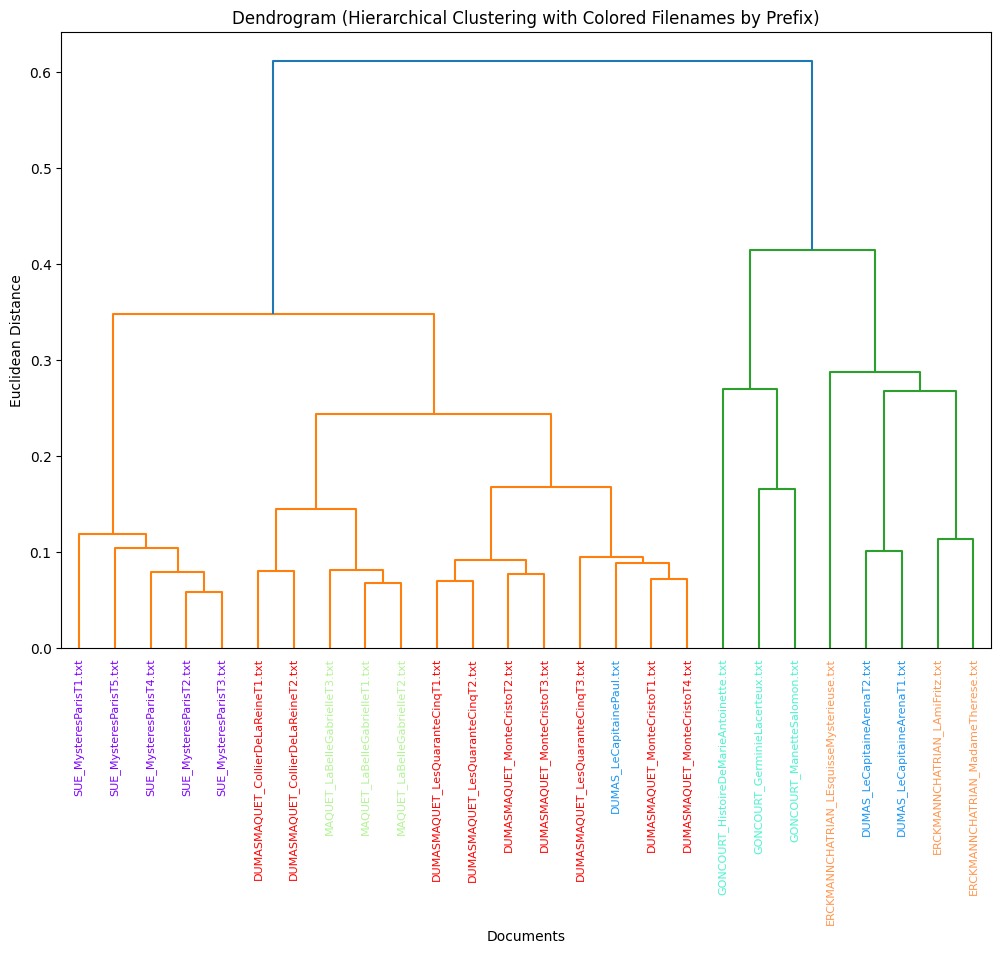

In [ ]:
# Using Euclidean distance and Ward's method for hierarchical clustering
distance_matrix = pdist(dtm_matrix, 'euclidean')
linkage_matrix = linkage(distance_matrix, 'ward')




# Extract prefixes from filenames
prefixes = [filename.split("_")[0] for filename in filtered_file_names]

# Get unique prefixes and assign each a unique color
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))  # Generate colors from a colormap
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

# Plot the Dendrogram with filenames as labels
plt.figure(figsize=(12, 8))
dendro = dendrogram(
    linkage_matrix,
    labels=filtered_file_names,    # Use filenames as labels
    leaf_rotation=90,     # Rotate labels for readability
    leaf_font_size=8,     # Adjust font size for readability
)
plt.title("Dendrogram (Hierarchical Clustering with Colored Filenames by Prefix)")
plt.xlabel("Documents")
plt.ylabel("Euclidean Distance")

# Apply colors to the labels based on the prefix
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for label in x_labels:
    filename = label.get_text()
    prefix = filename.split("_")[0]  # Get the prefix
    label.set_color(color_map[prefix])  # Set color based on prefix

plt.show()


### With cosine distance

Dunn Index: 0.1802


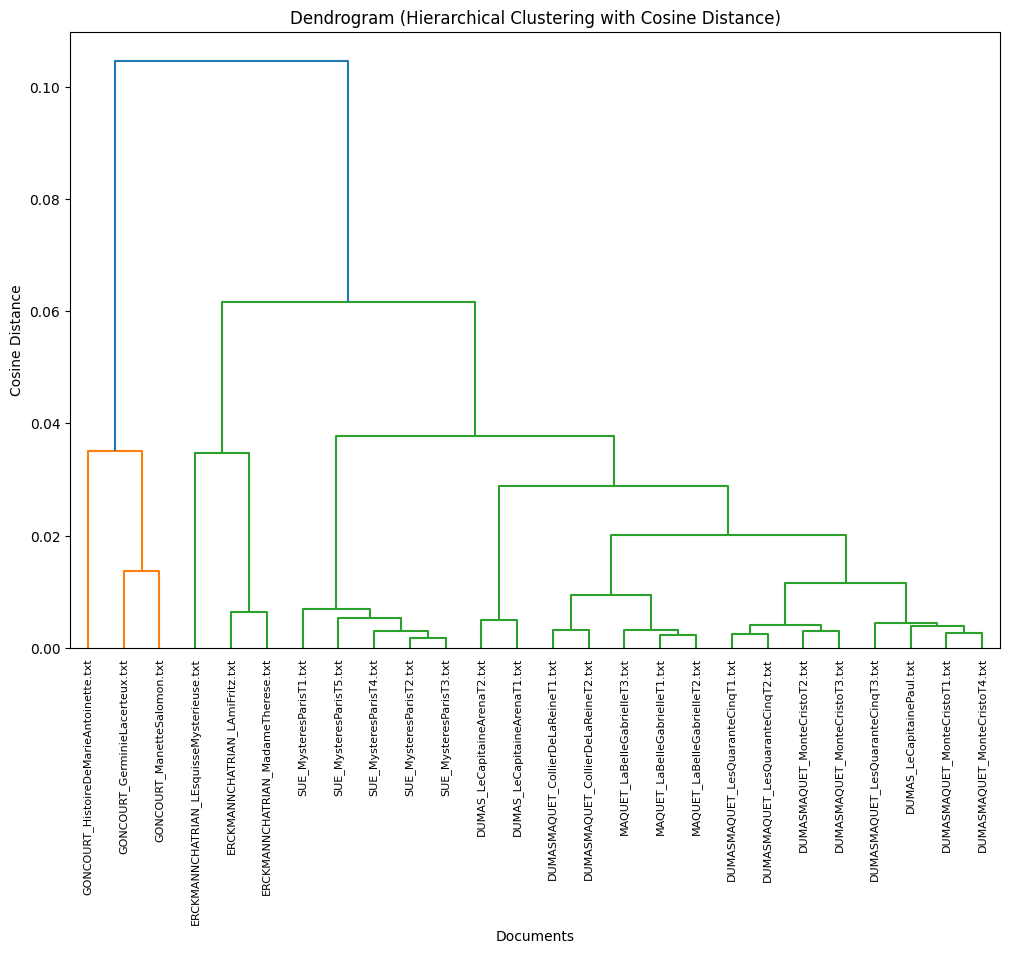

In [ ]:
# Using Cosine distance and Ward's method for hierarchical clustering
# Compute cosine distance matrix
distance_matrix = pdist(dtm_matrix, 'cosine')
linkage_matrix = linkage(distance_matrix, 'ward')

# Create clusters using a specified number of clusters
num_clusters = 5  # Adjust this value based on your dataset
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Calculate and display the Dunn Index
dunn_index = calculate_dunn_index(distance_matrix, clusters)
print(f"Dunn Index: {dunn_index:.4f}")

# Plot the Dendrogram with filenames as labels
plt.figure(figsize=(12, 8))
dendrogram(
    linkage_matrix,
    labels=filtered_file_names,    # Use filenames as labels
    leaf_rotation=90,     # Rotate labels for readability
    leaf_font_size=8,     # Adjust font size for readability
)
plt.title("Dendrogram (Hierarchical Clustering with Cosine Distance)")
plt.xlabel("Documents")
plt.ylabel("Cosine Distance")
plt.show()


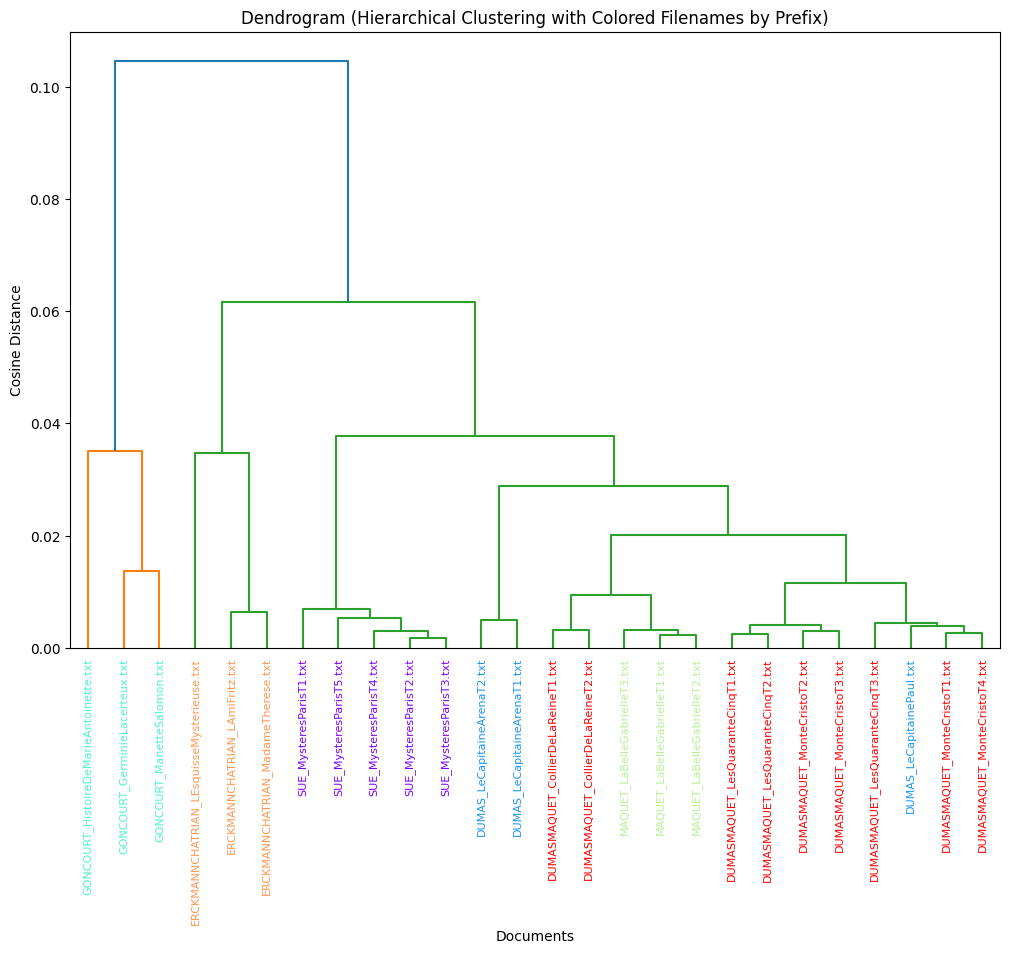

In [ ]:
# Using Cosine distance and Ward's method for hierarchical clustering
# Compute cosine distance matrix
distance_matrix = pdist(dtm_matrix, 'cosine')
linkage_matrix = linkage(distance_matrix, 'ward')

# Extract prefixes from filenames
prefixes = [filename.split("_")[0] for filename in filtered_file_names]

# Get unique prefixes and assign each a unique color
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))  # Generate colors from a colormap
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

# Plot the Dendrogram with filenames as labels
plt.figure(figsize=(12, 8))
dendro = dendrogram(
    linkage_matrix,
    labels=filtered_file_names,    # Use filenames as labels
    leaf_rotation=90,     # Rotate labels for readability
    leaf_font_size=8,     # Adjust font size for readability
)
plt.title("Dendrogram (Hierarchical Clustering with Colored Filenames by Prefix)")
plt.xlabel("Documents")
plt.ylabel("Cosine Distance")

# Apply colors to the labels based on the prefix
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for label in x_labels:
    filename = label.get_text()
    prefix = filename.split("_")[0]  # Get the prefix
    label.set_color(color_map[prefix])  # Set color based on prefix

plt.show()


It is sometimes recommanded to move away from Ward's method when using non-Euclidean distance measure. Ward's method indeed assumes a euclidean world.We could then set it to "average" for instance. Average linkage, unlike Ward’s method, does not assume or require Euclidean properties in the data. It doesn’t rely on assumptions about variance, so it adapts better to distances that reflect similarity or angular relationships rather than strict spatial positions.

Dunn Index: 0.5667


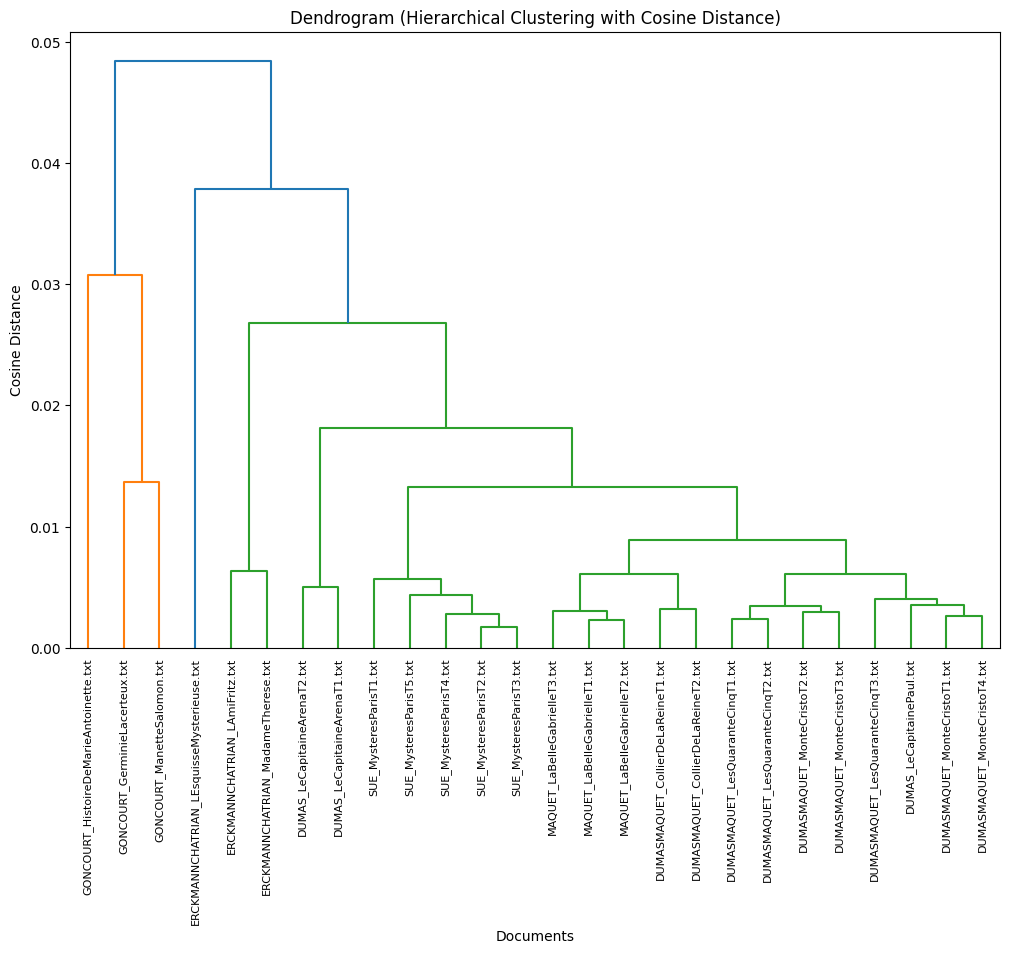

In [ ]:
# Using Cosine distance and Ward's method for hierarchical clustering
# Compute cosine distance matrix
distance_matrix = pdist(dtm_matrix, 'cosine')
linkage_matrix = linkage(distance_matrix, 'average')

# Create clusters using a specified number of clusters
num_clusters = 5  # Adjust this value based on your dataset
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Calculate and display the Dunn Index
dunn_index = calculate_dunn_index(distance_matrix, clusters)
print(f"Dunn Index: {dunn_index:.4f}")


# Plot the Dendrogram with filenames as labels
plt.figure(figsize=(12, 8))
dendrogram(
    linkage_matrix,
    labels=filtered_file_names,    # Use filenames as labels
    leaf_rotation=90,     # Rotate labels for readability
    leaf_font_size=8,     # Adjust font size for readability
)
plt.title("Dendrogram (Hierarchical Clustering with Cosine Distance)")
plt.xlabel("Documents")
plt.ylabel("Cosine Distance")
plt.show()



With label coloring

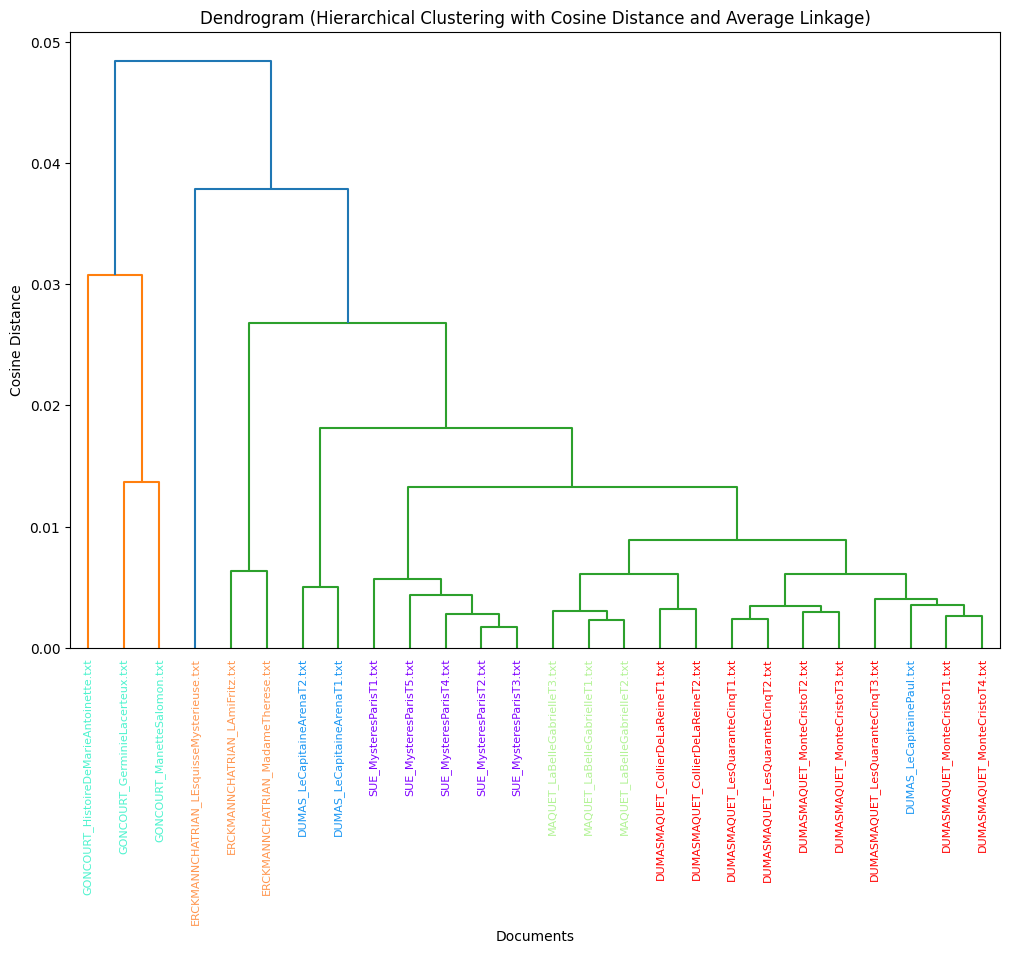

In [ ]:
# Using Cosine distance and Average linkage for hierarchical clustering
# Compute cosine distance matrix
distance_matrix = pdist(dtm_matrix, 'cosine')
linkage_matrix = linkage(distance_matrix, 'average')

# Extract prefixes from filenames
prefixes = [filename.split("_")[0] for filename in filtered_file_names]

# Get unique prefixes and assign each a unique color
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))  # Generate colors from a colormap
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

# Plot the Dendrogram with filenames as labels
plt.figure(figsize=(12, 8))
dendro = dendrogram(
    linkage_matrix,
    labels=filtered_file_names,    # Use filenames as labels
    leaf_rotation=90,     # Rotate labels for readability
    leaf_font_size=8,     # Adjust font size for readability
)
plt.title("Dendrogram (Hierarchical Clustering with Cosine Distance and Average Linkage)")
plt.xlabel("Documents")
plt.ylabel("Cosine Distance")

# Apply colors to the labels based on the prefix
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for label in x_labels:
    filename = label.get_text()
    prefix = filename.split("_")[0]  # Get the prefix
    label.set_color(color_map[prefix])  # Set color based on prefix

plt.show()



## K-means

Cluster Labels: [2 2 0 0 0 0 0 0 0 0 0 0 2 2 2 1 4 1 0 0 0 3 3 3 3 3]
Silhouette Score for K-Means clustering: 0.2546988522889922


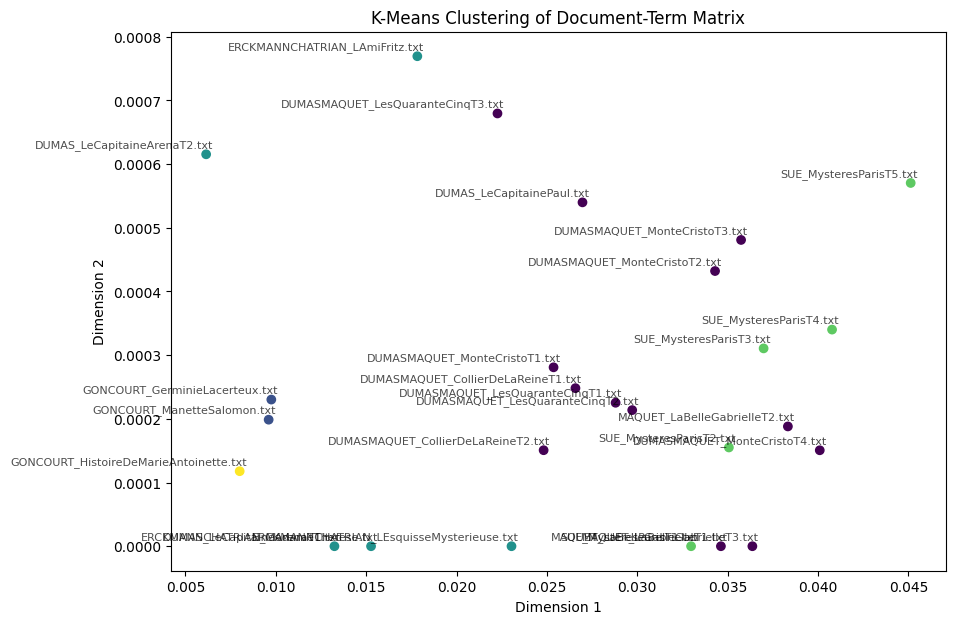

In [ ]:
# K-Means Clustering as an alternative to Hierarchical Clustering
kmeans = KMeans(n_clusters=5, random_state=42) #set the number of clusters appropriately, depending on the number of expected authors (when known)
kmeans_labels = kmeans.fit_predict(dtm_matrix)
print("Cluster Labels:", kmeans_labels)

# Silhouette Score to assess clustering performance
silhouette_avg = silhouette_score(dtm_matrix, kmeans_labels)
print("Silhouette Score for K-Means clustering:", silhouette_avg)

# Plot the K-Means Clustering result with labels
plt.figure(figsize=(10, 7))
plt.scatter(dtm_matrix[:, 0], dtm_matrix[:, 1], c=kmeans_labels, cmap='viridis')

# Add file names as labels for each point
for i, filename in enumerate(filtered_file_names):
    plt.annotate(
        filename,
        (dtm_matrix[i, 0], dtm_matrix[i, 1]),
        textcoords="offset points",
        xytext=(5, 5),  # Offset label to avoid overlap with the point
        ha="right",
        fontsize=8,     # Adjust font size for readability
        alpha=0.7       # Slight transparency for better readability
    )

plt.title("K-Means Clustering of Document-Term Matrix")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


## Heatmap

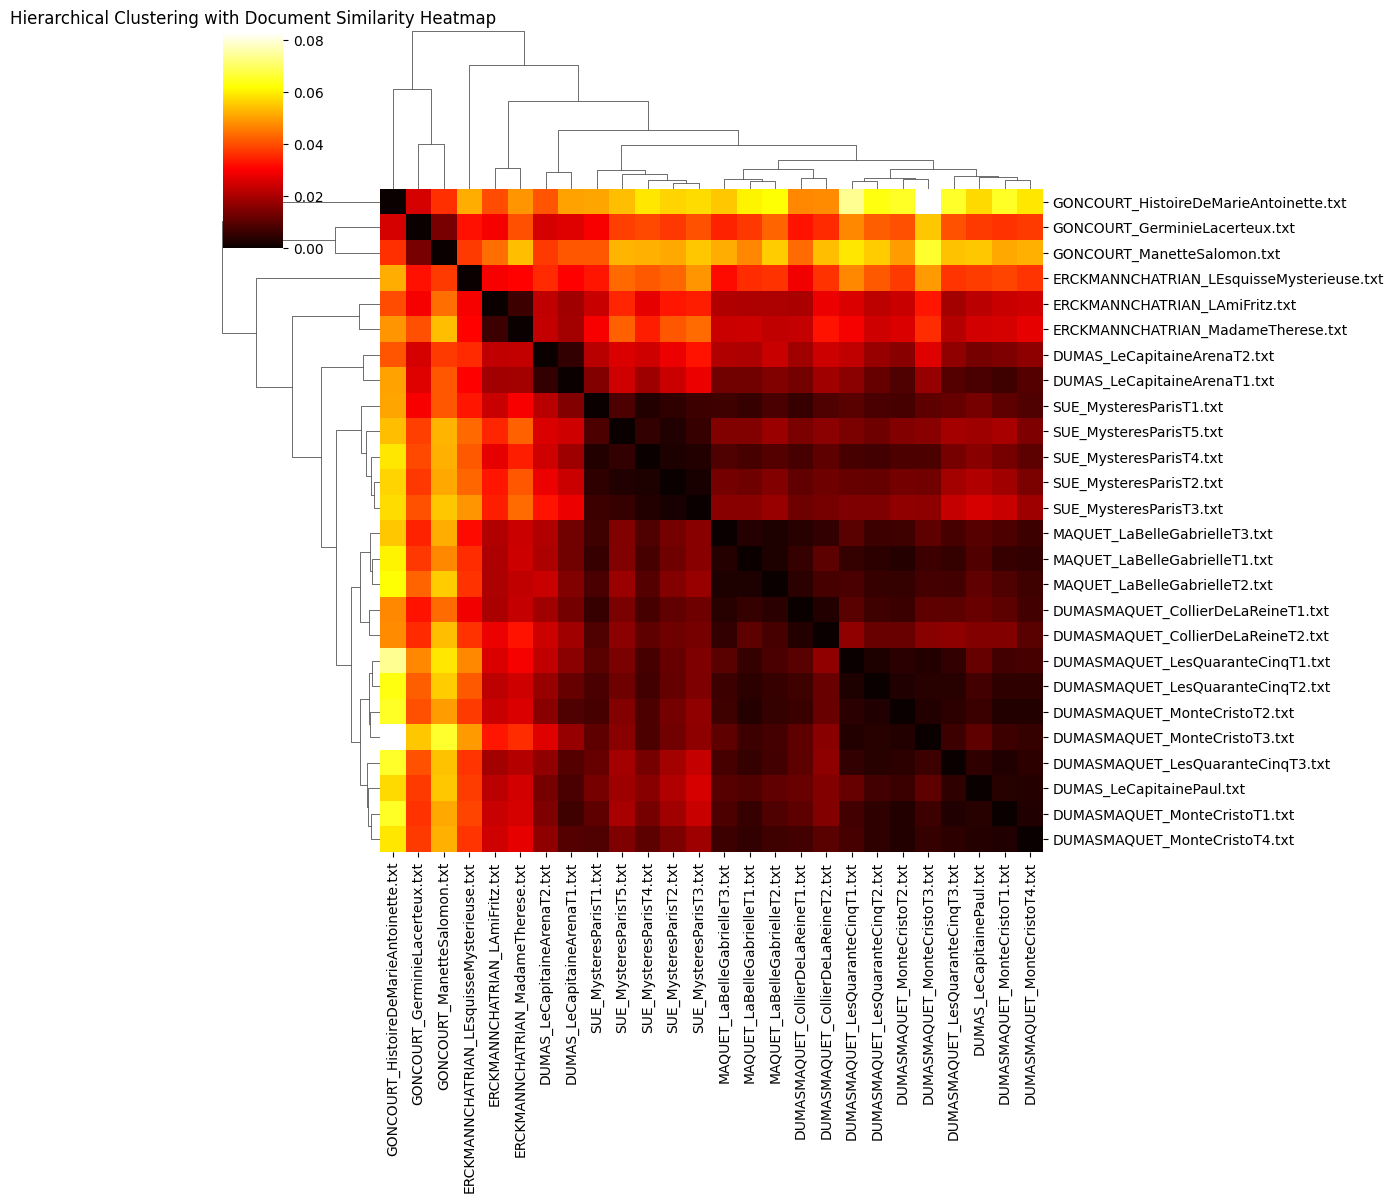

In [ ]:
# Compute cosine distance matrix
distance_matrix = pdist(dtm_matrix, 'cosine')
distance_squareform = squareform(distance_matrix)

# Extract prefixes from filenames
prefixes = [filename.split("_")[0] for filename in filtered_file_names]

# Assign unique colors to each prefix
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))  # Generate colors from a colormap
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}
row_colors = [color_map[prefix] for prefix in prefixes]  # Map colors to each document based on prefix

# Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='average')  # You can choose other methods (e.g., 'ward', 'complete')

# Create a DataFrame for `seaborn.clustermap`
distance_df = pd.DataFrame(distance_squareform, index=filtered_file_names, columns=filtered_file_names)

# Plot clustermap with hierarchical clustering and colored labels
sns.clustermap(
    distance_df,
    cmap="hot",                        # Heatmap color map
    row_linkage=linkage_matrix,        # Use the linkage matrix for clustering rows
    col_linkage=linkage_matrix,        # Use the same linkage matrix for columns (symmetric matrix)
    figsize=(12, 12),                  # Adjust size as needed
    xticklabels=filtered_file_names,   # Show filenames on x-axis
    yticklabels=filtered_file_names    # Show filenames on y-axis
)

plt.title("Hierarchical Clustering with Document Similarity Heatmap")
plt.show()


### Clustermap

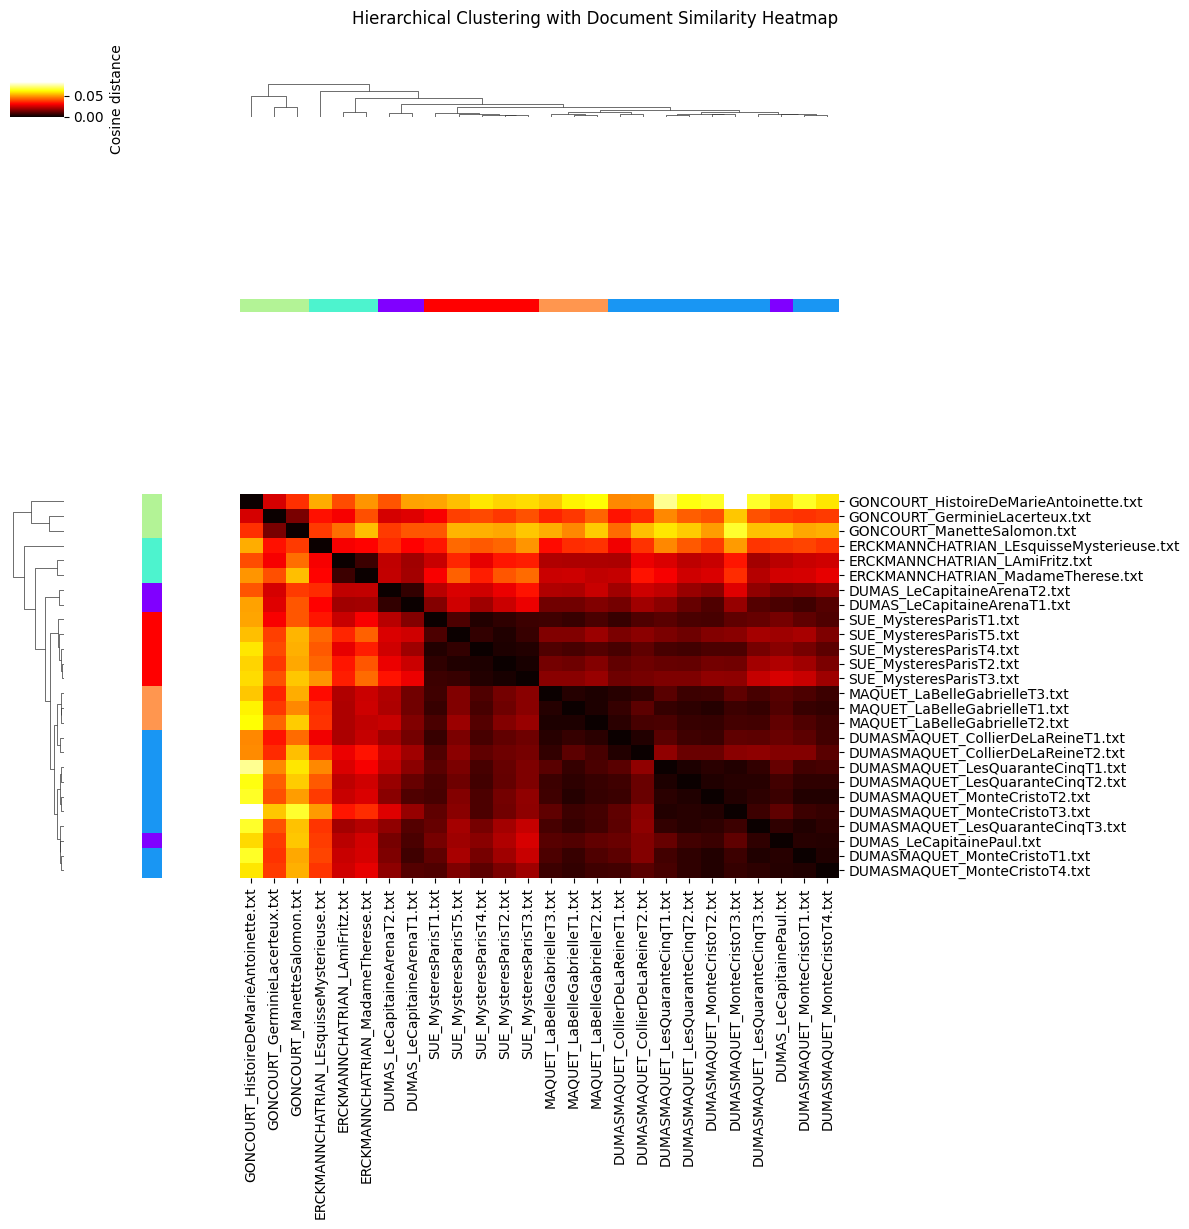

In [ ]:
# --- Cosine-distance clustermap (Colab-ready, same spirit as your old cell) ---

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from matplotlib import cm
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage

# 1) Compute cosine distances (condensed + square)
distance_matrix = pdist(dtm_matrix, metric='cosine')
distance_squareform = squareform(distance_matrix)

# 2) Names (use filtered names to stay aligned after outlier removal)
names = file_names
assert len(names) == distance_squareform.shape[0], "Names must match matrix size"

# 3) Prefix-based colors (stable order to keep colors consistent)
prefixes = [fn.split("_")[0] for fn in names]
unique_prefixes = sorted(set(prefixes))                        # stable mapping
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))
color_map = {p: c for p, c in zip(unique_prefixes, colors)}
row_colors = [color_map[p] for p in prefixes]

# 4) Hierarchical clustering from the condensed distances
linkage_matrix = linkage(distance_matrix, method='average')    # same method as before

# 5) DataFrame for seaborn.clustermap
distance_df = pd.DataFrame(distance_squareform, index=names, columns=names)

# 6) Plot clustermap (distance heatmap, like before)
g = sns.clustermap(
    distance_df,
    cmap="hot",                                # same look & feel
    row_linkage=linkage_matrix,
    col_linkage=linkage_matrix,
    row_colors=row_colors,
    col_colors=row_colors,
    figsize=(12, 12),
    xticklabels=True,                          # labels come from distance_df columns
    yticklabels=True,
    cbar_kws={"label": "Cosine distance"},
    dendrogram_ratio=(0.08, 0.08)
)

# Proper title for clustermap objects + guaranteed display in Colab/Jupyter
g.fig.suptitle("Hierarchical Clustering with Document Similarity Heatmap", y=1.02)
g.fig.tight_layout()
plt.show(g.fig)


## Mann-Whitney

In [ ]:
## Mann-Whitney test example
# An example of a Mann-Whitney test comparing two sample document groups
# Select two document groups for the test (adjust indices as needed)
group1 = dtm_matrix[:5].sum(axis=0)
group2 = dtm_matrix[5:10].sum(axis=0)
stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
print("Mann-Whitney test result: statistic =", stat, ", p-value =", p_value)

Mann-Whitney test result: statistic = 50484.0 , p-value = 0.8647491216766795
